## Import Libraries and Input Key Functions

In [32]:
# Jupyer Notebook Theme: jt -t monokai -f fira -fs 10 -nf ptsans -nfs 11 -N -kl -cursw 2 -cursc r -cellw 95% -T
# Check python version
import sys
cdPyVer = 0x600
cdSysVer = sys.version[:5]
print("%s%s" %("My python version is: ", cdSysVer)) # strangely it works only on 3.7.4 and not 3.7.6

# Import libraries
import pandas as pd 
import numpy as np
import warnings

# Progress Bar
from tqdm.auto import tqdm

# Visualisation Libraries
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.gridspec import GridSpec
plt.style.use('seaborn-dark') # use this theme as you are using dark theme in the notebook
import seaborn as sns
import folium
from folium.plugins import HeatMap, FastMarkerCluster

# Utility Modules
sys.path.append('/Users/Shandeep/data_science/delivery_hero')


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
              
warnings.filterwarnings('ignore')

My python version is: 3.9.7


#### BQ Table/Schema Functions

In [33]:
def bq_table_info(bqclient, project, dataset, table):
    "print table details from BQ API"
    t = bqclient.get_table(f'{project}.{dataset}.{table}')

    print( 'Type:          ', t.table_type)
    print(f'Row count:      {t.num_rows:,}')
    print( 'Column count:  ', len(t.schema))
    print( 'Size:          ', u.convert_bytes(t.num_bytes))
    print( 'Table created: ', str(t.created)[:19])
    print( 'Last modified: ', str(t.modified)[:19])
    print( 'Description:   ', t.description)
    print( 'Labels:        ', t.labels)
    print( 'Partitioned by:', t.partitioning_type)
    print( 'GCP location:  ', t.location)
    
def bq_schema_df(bqclient, project, dataset, table) -> pd.DataFrame:
    "return dataframe with schema details"
    table_obj = bqclient.get_table(f'{project}.{dataset}.{table}')
    schema = table_obj.schema
    
    df = pd.DataFrame(index=range(len(schema)),
                      data = {'name': [col.name       for col in schema],
                              'type': [col.field_type for col in schema],
                              'mode': [col.mode       for col in schema],
                              'description': [col.description for col in schema]
                             })
    
    return df
  


## Connection to BigQuery

In [34]:
"""
Connect to big query and then run analysis acordingly.
"""

import sys
sys.path.append('/Users/Shandeep/qc_data_insights/utils/') # git clone this repository qc_data_insights
from utils import utils

import os
from google.oauth2 import service_account
# pip install google-cloud-bigquery==1.24.0 # requires this version.. current version is bugged with pandas
from google.cloud import bigquery

google_credentials_path = os.path.expanduser('~')+'/Documents/google_cloud_data-insights-team.json' # make sure add json file credentials in documents folder
credentials = service_account.Credentials.from_service_account_file(google_credentials_path)
bqclient = bigquery.Client(credentials=credentials, project=credentials.project_id)
print(f'Connected to BigQuery, project: {bqclient.project} on version {bigquery.__version__}')
print(f'Service Account Email: {bqclient.get_service_account_email()}')

Connected to BigQuery, project: dh-darkstores-live on version 1.24.0
Service Account Email: bq-1010543247368@bigquery-encryption.iam.gserviceaccount.com


## Table Information

In [35]:
from utils import qa
project = 'dh-darkstores-live'
dataset = 'cl_data_science_qcommerce'
table   = '_promo_roi_out_roi_tableau_report'

t = bqclient.get_table(f'{project}.{dataset}.{table}')
print(f'Table: {project}.{dataset}.{table}')
print("____________________________________________________________________")
print("")
print(qa.bq_table_info(bqclient, project, dataset, table))

Table: dh-darkstores-live.cl_data_science_qcommerce._promo_roi_out_roi_tableau_report
____________________________________________________________________

type:           TABLE
row count:      3,637,475
column count:   38
size:           1.42 GB
table created:  2021-12-08 23:18:19
last modified:  2021-12-08 23:18:19
description:    Promo ROI Model Tableau Report
labels:         {}
partitioned by: DAY
GCP location:   US
None


#### Schema

In [36]:
schema_df = bq_schema_df(bqclient, project, dataset, table)
print(schema_df.groupby('type')['name'].count()) 
schema_df

type
BOOLEAN       1
DATE          2
FLOAT        17
INTEGER       1
STRING       14
TIMESTAMP     3
Name: name, dtype: int64


,name,type,mode,description
0,order_date,DATE,NULLABLE,None
1,global_entity_id,STRING,NULLABLE,None
2,warehouse,STRING,NULLABLE,None
3,supplier,STRING,NULLABLE,None
4,sku,STRING,NULLABLE,None
5,no_of_campaigns,INTEGER,NULLABLE,None
6,campaign_id,STRING,NULLABLE,None
7,campaign_name,STRING,NULLABLE,None
8,campaign_created_time_utc,TIMESTAMP,NULLABLE,None
9,campaign_start_time_utc,TIMESTAMP,NULLABLE,None


#### Column types

In [37]:
cols_numeric  = schema_df.loc[schema_df['type'].isin(['FLOAT', 'INTEGER', 'NUMERIC']),   'name'].values
cols_datetime = schema_df.loc[schema_df['type'].isin(['DATE', 'DATETIME', 'TIMESTAMP']), 'name'].values
cols_boolean  = schema_df.loc[schema_df['type'].isin(['BOOLEAN']),                       'name'].values
cols_object   = schema_df.loc[schema_df['type'].isin(['STRING', ]),                      'name'].values

In [38]:
# Some types are not supported by pandas
cols_not_supported = schema_df.loc[schema_df['type']=='RECORD', 'name'].values
cols_not_supported

array([], dtype=object)

#### Query

In [39]:
# WHERE RAND() < 10000/{t.num_rows} --- Add this if you are looking for 100000 random rows
query =f""" 
SELECT *
FROM `{project}.{dataset}.{table}`
WHERE RAND() < 10000/{t.num_rows}
"""
# Read query and display in the form of a pandas dataframe
df = utils.read_bigquery(query, bqclient, parse_dates=[], verbose=True)
df.head()

running query... job done, downloading... 

Downloading:   0%|          | 0/10010 [00:00<?, ?rows/s]

done with shape (10010, 38)


,order_date,global_entity_id,warehouse,supplier,sku,no_of_campaigns,campaign_id,campaign_name,campaign_created_time_utc,campaign_start_time_utc,campaign_end_time_utc,is_campaign_active,category,subcategory,brand,product,y_pred_base,y_pred,b_qty,qty_sold,incremental_quantity_tab,is_outlier_incremental_quantity,price_base,price,cost,b_gmv,gmv,incremental_gmv_tab,is_outlier_incremental_gmv,b_profit,profit,profit_ext,incremental_profit_ext_tab,is_outlier_incremental_profit_ext,execution_date,confidence,discount,externally_funded_percentage
0,2020-04-22,FP_TW,熊貓超市(中山店),0008 瑛珊股份有限公司,14020026,2,be4f9017-70bb-40ef-bcea-bb3e8484fa8d,14020026_Zhongshan,2020-04-21 10:39:07+00:00,2020-04-21 11:00:00+00:00,2020-05-27 16:00:00+00:00,True,grains & rice &noodles,Cup Instant Noodle,UNKNOWN BRAND,Pork cup Instant Noodles71g*3,1.08,1.45,0.74,1.0,35.135135,No,73.00,65.00,59.57,54.06,65.00,20.236774,No,9.94,5.43,5.43,-45.372233,No,2021-12-08,medium,11.0,0.0
1,2020-02-22,FP_SG,Bukit Batok,Toll Distribution Center,C2DLTS,3,2693586a-8195-40e8-92f5-beb5ac228230,Doritos Nacho Cheese Tortilla Chips 198.4g,2020-02-07 06:00:52+00:00,2020-02-09 17:00:00+00:00,2020-02-23 15:00:00+00:00,True,Snacks,Potato Chips,Lay's,Lays Classic | 184.2 g,3.33,4.83,2.07,3.0,44.927536,No,4.75,4.20,3.55,9.82,12.60,28.309572,No,2.48,1.95,3.60,45.161290,No,2021-12-01,very high,12.0,100.0
2,2020-03-08,FP_SG,Bukit Batok,Toll Distribution Center,W8FXXF,4,301bc719-0529-482d-93b1-0550f4292b5f,Biore Pore Pack Black 10S,2020-03-03 08:50:31+00:00,2020-03-03 09:00:00+00:00,2020-03-08 15:00:00+00:00,True,Beauty & Personal Care,Feminine Care,Laurier,Laurier Safety Comfort Night Pads 30cm 16s,1.74,2.13,0.81,1.0,23.456790,No,4.95,4.46,4.00,4.03,4.46,10.669975,No,0.77,0.46,0.95,23.376623,No,2021-12-08,medium,10.0,100.0
3,2020-07-06,FP_SG,Bukit Batok,Toll Distribution Center,7K86VS,3,88caede3-b2da-4143-ae19-fc65bc8349cf,Chang Beer CAN,2020-07-06 03:35:48+00:00,2020-07-06 04:00:00+00:00,2020-07-19 16:00:00+00:00,True,"Wine, Beer, Spirits",Beer (Single),Chang,Chang Beer Can | 500 ml,8.28,15.23,9.79,18.0,83.861083,No,4.30,3.50,3.25,42.09,63.00,49.679259,No,10.28,4.50,18.90,83.852140,No,2021-12-08,medium,19.0,100.0
4,2020-07-06,FP_SG,Yishun,Toll Distribution Center,C65ZV1,2,abce2567-1b6d-43c4-ab3f-c5dcdd65b13c,Sheba Flaked Tuna In Gravy Cat Food 85g,2020-07-04 16:39:17+00:00,2020-07-05 16:00:00+00:00,2020-07-12 16:00:00+00:00,True,Pets,Cat Food,Sheba,Sheba Tuna & Snapper in Gravy Cat Food 85g,6.55,8.57,5.35,7.0,30.841121,No,1.40,1.26,1.03,7.49,8.82,17.757009,No,1.98,1.61,2.59,30.808081,No,2021-11-04,very high,10.0,100.0


#### Country Representation in Dataset

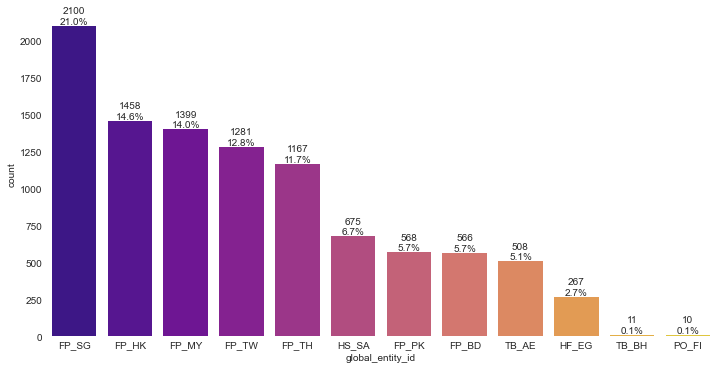

In [40]:
from utils import viz_utils
fig, ax = plt.subplots(figsize=(12, 6))
viz_utils.single_countplot(df, x='global_entity_id', ax=ax)
plt.show()

#### Datapoints by Order Date

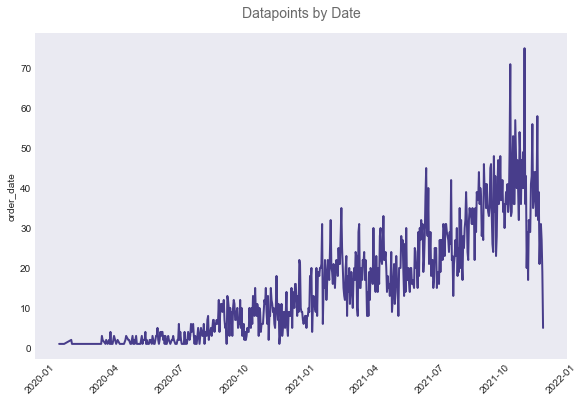

In [41]:


fig = plt.figure(constrained_layout=True, figsize=(8, 10))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])


# Lineplot - Evolution of e-commerce orders along time 
sns.lineplot(data=df['order_date'].value_counts().sort_index(), ax=ax1, 
             color='darkslateblue', linewidth=2)

for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax1.set_title('Datapoints by Date', y = 1.03, size=14, color='dimgrey');



In [42]:
df[df.duplicated()].head()# don't know why it's not working as expected

,order_date,global_entity_id,warehouse,supplier,sku,no_of_campaigns,campaign_id,campaign_name,campaign_created_time_utc,campaign_start_time_utc,campaign_end_time_utc,is_campaign_active,category,subcategory,brand,product,y_pred_base,y_pred,b_qty,qty_sold,incremental_quantity_tab,is_outlier_incremental_quantity,price_base,price,cost,b_gmv,gmv,incremental_gmv_tab,is_outlier_incremental_gmv,b_profit,profit,profit_ext,incremental_profit_ext_tab,is_outlier_incremental_profit_ext,execution_date,confidence,discount,externally_funded_percentage


#### Data types

In [43]:
df.dtypes

order_date                                        object
global_entity_id                                  object
warehouse                                         object
supplier                                          object
sku                                               object
no_of_campaigns                                    int64
campaign_id                                       object
campaign_name                                     object
campaign_created_time_utc            datetime64[ns, UTC]
campaign_start_time_utc              datetime64[ns, UTC]
campaign_end_time_utc                datetime64[ns, UTC]
is_campaign_active                                  bool
category                                          object
subcategory                                       object
brand                                             object
product                                           object
y_pred_base                                      float64
y_pred                         

In [44]:
cols_numeric

array(['no_of_campaigns', 'y_pred_base', 'y_pred', 'b_qty', 'qty_sold',
       'incremental_quantity_tab', 'price_base', 'price', 'cost', 'b_gmv',
       'gmv', 'incremental_gmv_tab', 'b_profit', 'profit', 'profit_ext',
       'incremental_profit_ext_tab', 'discount',
       'externally_funded_percentage'], dtype=object)

In [45]:
cols_object

array(['global_entity_id', 'warehouse', 'supplier', 'sku', 'campaign_id',
       'campaign_name', 'category', 'subcategory', 'brand', 'product',
       'is_outlier_incremental_quantity', 'is_outlier_incremental_gmv',
       'is_outlier_incremental_profit_ext', 'confidence'], dtype=object)

In [46]:
for col in cols_numeric:
    df[col] = pd.to_numeric(df[col], errors='raise')

cols_numeric_2 = ['no_of_campaigns', 'y_pred_base', 'y_pred', 'b_qty', 'qty_sold',
       'incremental_quantity_tab', 'price_base', 'price', 'cost', 'b_gmv',
       'gmv', 'incremental_gmv_tab', 'b_profit', 'profit', 'profit_ext',
       'incremental_profit_ext_tab', 'discount',
       'externally_funded_percentage']
    
for col in cols_numeric_2:
    df[col] = pd.to_numeric(df[col], errors='raise')

for col in cols_datetime:
    df[col] = pd.to_datetime(df[col], errors='raise').dt.date

for col in cols_boolean:
    df[col] = df[col].astype(bool)

In [47]:
# Convert object types to date
date_columns = [columns for columns in df.columns if 'date' in columns or 'time' in columns]
print(date_columns)
for col in date_columns:
    df[col] = pd.to_datetime(df[col]).dt.date
df['number_of_campaign_days'] = (df['campaign_end_time_utc'] - df['campaign_start_time_utc']).dt.days

['order_date', 'campaign_created_time_utc', 'campaign_start_time_utc', 'campaign_end_time_utc', 'execution_date']


### Dataset deep dive

In [48]:
utils.df_info(df).style.background_gradient(subset=['isnull_%'], cmap='Reds')

,column,dtype,memory_mb,nunique,notnull,isnull,isnull_%,min,max
0,order_date,object,0.400000,601,10010,0,0.000000,2020-01-28,2021-12-07
1,global_entity_id,object,0.620000,12,10010,0,0.000000,FP_BD,TB_BH
2,warehouse,object,0.740000,342,10010,0,0.000000,6th Of October - 4th District,熊貓超市(高雄三民店)
3,supplier,object,0.970000,612,10010,0,0.000000,Kao (Hong Kong) Limited,lfad Multi Products Ltd
4,sku,object,0.630000,3330,10010,0,0.000000,00011F,ZZMD71
5,no_of_campaigns,int64,0.080000,14,10010,0,0.000000,1,24
6,campaign_id,object,0.930000,3928,10010,0,0.000000,002bf9e9-c3ec-4788-9b5a-e65ccd190c9c,ffffd406-76bd-48dd-ac64-00b71c8450d6
7,campaign_name,object,0.930000,3674,10010,0,0.000000,(IATCO) Kinder - Sep,w24_hero1_ncr_brandweek_dksh_flash_tier1_day3
8,campaign_created_time_utc,object,0.400000,517,10010,0,0.000000,2019-12-19,2021-12-06
9,campaign_start_time_utc,object,0.400000,522,10010,0,0.000000,2019-12-23,2021-12-06


In [49]:
# Check out why it is null
# (price base - cost) * b_qty = b_profit
df[df.incremental_profit_ext_tab.isna()][['price_base','cost','b_qty','b_profit','profit_ext','incremental_profit_ext_tab']].head()

,price_base,cost,b_qty,b_profit,profit_ext,incremental_profit_ext_tab
765,13.0,13.0,5.70,0.0,-4.10,NaN
7905,120.0,120.0,14.91,0.0,-554.12,NaN
8405,49.0,49.0,6.66,0.0,-83.10,NaN


#### Category Insights

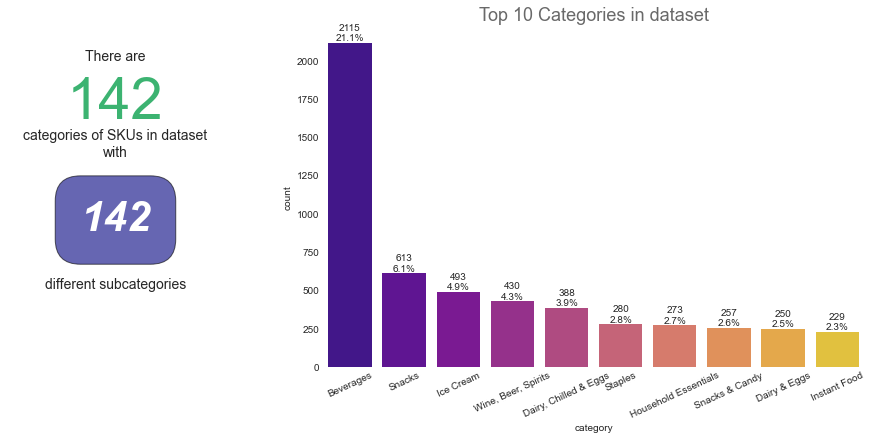

In [50]:
# Building a figure
fig = plt.figure(constrained_layout=True, figsize=(12, 6))

# Axis definition with GridSpec
gs = GridSpec(1, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:3])

# Axis 1 - Big Number for total categories and subcategories in the data
total_categories = len(df['category'].value_counts())
total_subcategories = len(df['category'].value_counts())
ax1.text(0.4, 0.9, 'There are', fontsize=14, ha='center')
ax1.text(0.4, 0.73, f'{total_categories}', fontsize=58, color='mediumseagreen', ha='center')
ax1.text(0.4, 0.62, f'categories of SKUs in dataset\nwith', fontsize=14, ha='center')
ax1.text(0.4, 0.4, total_subcategories, fontsize=42, ha='center', color='white', style='italic', weight='bold',
         bbox=dict(facecolor='navy', alpha=0.6, pad=16, boxstyle='round, pad=.6'))
ax1.text(0.4, 0.23, 'different subcategories', fontsize=14, ha='center')
ax1.axis('off')

# Axis 2 - Total number of subcategories
top = 10
viz_utils.single_countplot(df, ax2, x='category', top=top)
ax2.set_title(f'Top {top} Categories in dataset', color='dimgrey', size=18)
for tick in ax2.get_xticklabels():
    tick.set_rotation(25)

In [51]:
popular_categories = df.groupby(by='category', as_index=False).agg({'sku': 'count',
                                                                                    'gmv': 'mean',
                                                                                    'qty_sold': 'mean',
                                                                                    'profit': 'mean',
                                                                                    'externally_funded_percentage': 'mean'})
popular_categories.columns = ['category', 'total_skus', 'mean_gmv', 'mean_qty_sold', 'mean_profit', 'mean_supplier_finding']
popular_categories = popular_categories.sort_values(by='mean_qty_sold', ascending=False)
popular_categories = popular_categories.loc[:, ['category', 'total_skus', 'mean_gmv', 'mean_qty_sold', 'mean_profit', 'mean_supplier_finding']]
popular_categories.head()

,category,total_skus,mean_gmv,mean_qty_sold,mean_profit,mean_supplier_finding
49,Dairy Products,35,3931.894571,27.600000,129.876286,10.000000
56,"Egg, Meat & Fish",35,3129.390857,27.571429,-512.562286,1.428571
138,Water,96,146.014792,22.197917,26.467187,9.375000
94,"Meat, Fruits & Vegetables",17,1156.544706,21.117647,7.524118,0.000000
21,Cafeteria,1,537.760000,16.000000,130.080000,0.000000


#### Boolean Columns

In [52]:
cols_boolean

array(['is_campaign_active'], dtype=object)

In [53]:
# Columns that start with "is"
print(df.filter(regex='^is',axis=1).columns)

Index(['is_campaign_active', 'is_outlier_incremental_quantity',
       'is_outlier_incremental_gmv', 'is_outlier_incremental_profit_ext'],
      dtype='object')


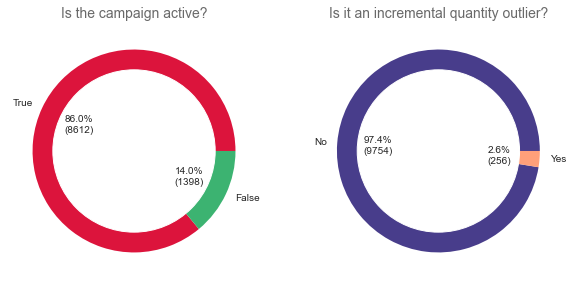

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
viz_utils.donut_plot(df, col='is_campaign_active', colors=['crimson', 'mediumseagreen'], ax=axs[0], 
           title='Is the campaign active?')
viz_utils.donut_plot(df, col='is_outlier_incremental_quantity', colors=['darkslateblue', 'lightsalmon'], ax=axs[1], 
           title='Is it an incremental quantity outlier?')

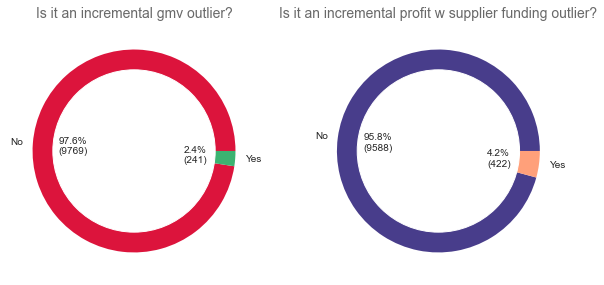

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
viz_utils.donut_plot(df, col='is_outlier_incremental_gmv', colors=['crimson', 'mediumseagreen'], ax=axs[0], 
           title='Is it an incremental gmv outlier?')
viz_utils.donut_plot(df, col='is_outlier_incremental_profit_ext', colors=['darkslateblue', 'lightsalmon'], ax=axs[1], 
           title='Is it an incremental profit w supplier funding outlier?')

### Numerical Columns

In [56]:
# Add number of campaign days to colums_numeric
cols_numeric = np.append(cols_numeric,['number_of_campaign_days'])

# Look at values based on percentiles
desc = df.loc[:, cols_numeric].describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
for col in desc.columns:
    desc[col] = np.round(desc[col], 2)
    
utils.display_df(desc)

,no_of_campaigns,y_pred_base,y_pred,b_qty,qty_sold,incremental_quantity_tab,price_base,price,cost,b_gmv,gmv,incremental_gmv_tab,b_profit,profit,profit_ext,incremental_profit_ext_tab,discount,externally_funded_percentage,number_of_campaign_days
count,10010.00,10010.00,10010.00,10010.00,10010.00,10010.00,10010.00,10010.00,10010.00,10010.00,10010.00,10010.00,10010.00,10010.00,10010.00,10007.00,10010.00,10010.00,10010.00
mean,1.71,3.89,5.79,3.95,5.86,51.58,39.79,34.37,29.54,144.10,181.32,24.89,31.95,17.43,25.87,-10.26,15.03,51.16,80.73
std,1.39,5.37,8.95,6.38,10.25,96.02,88.18,78.85,66.66,542.27,679.37,53.93,86.49,109.71,124.11,258.13,9.73,45.67,1318.36
min,1.00,0.11,0.59,0.03,1.00,1.01,0.18,0.15,0.18,0.33,0.54,0.00,-265.38,-5025.00,-5025.00,-14416.24,1.00,0.00,0.00
1%,1.00,0.82,1.23,0.44,1.00,5.63,1.11,0.90,0.80,1.20,1.40,0.21,0.25,-58.21,-40.87,-339.35,2.00,0.00,0.00
5%,1.00,1.14,1.55,0.64,1.00,10.19,1.60,1.39,1.20,2.73,3.24,1.30,0.60,-5.00,-0.60,-118.71,4.00,0.00,1.00
10%,1.00,1.30,1.78,0.74,1.00,13.64,2.25,1.90,1.70,4.48,5.47,2.78,1.04,-0.81,0.41,-77.19,5.00,0.00,3.00
25%,1.00,1.68,2.33,0.95,2.00,21.21,5.20,4.30,3.75,11.61,13.90,7.01,2.69,0.65,2.00,-25.92,9.00,0.00,6.00
50%,1.00,2.42,3.50,2.21,3.00,35.14,15.28,13.05,11.00,32.97,39.42,15.34,7.80,3.75,7.44,8.50,13.00,66.67,10.00
75%,2.00,4.04,5.85,4.34,6.00,58.73,38.38,32.90,27.14,102.22,125.26,29.24,25.12,15.79,23.74,30.12,20.00,100.00,21.00


#### Numerical Distributions

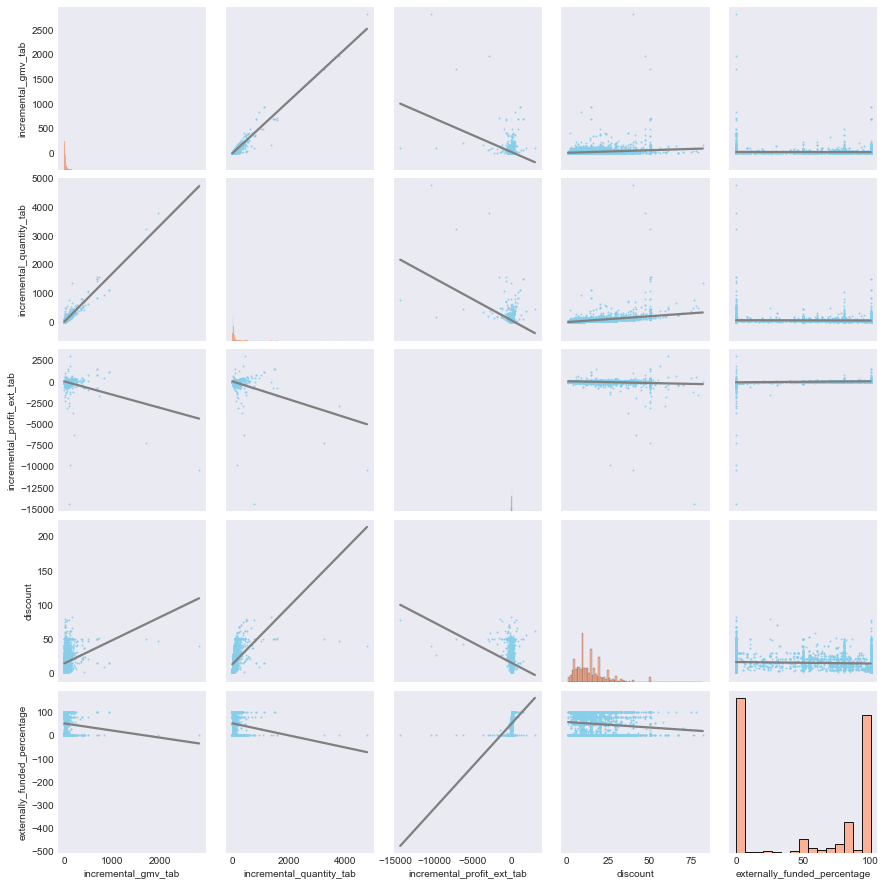

In [57]:
sns.pairplot(df, vars = ['incremental_gmv_tab','incremental_quantity_tab','incremental_profit_ext_tab','discount','externally_funded_percentage'], 
             kind = 'reg',
             diag_kws = {'color': 'lightsalmon'},
             plot_kws = {'ci':None, 'color': 'gray',
                        'scatter_kws': {'color':'skyblue', 's':1}
                        }
            
            );

#### Boxplots & Histplots for the entire dataset

,incremental_gmv_tab,incremental_quantity_tab,incremental_profit_ext_tab
count,10010.00,10010.00,10007.00
mean,24.89,51.58,-10.26
std,53.93,96.02,258.13
min,0.00,1.01,-14416.24
0%,0.00,1.01,-14416.24
25%,7.01,21.21,-25.92
50%,15.34,35.14,8.50
75%,29.24,58.73,30.12
100%,2813.91,4767.26,3019.90
max,2813.91,4767.26,3019.90


None

Text(0.5, 0, 'Distribution of Incremental Profit')

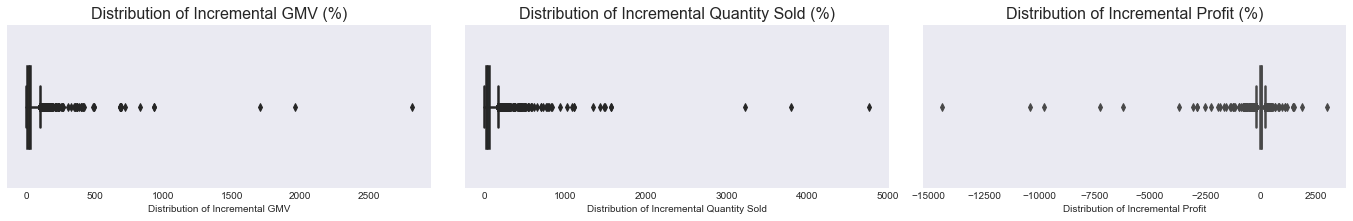

In [58]:
desc = df[['incremental_gmv_tab','incremental_quantity_tab','incremental_profit_ext_tab']].describe(percentiles=[0, 0.25, 0.5, 0.75, 1])
for col in desc.columns:
    desc[col] = np.round(desc[col], 2)
    
display(utils.display_df(desc))

fig, ax = plt.subplots(1,3, figsize = (24,3), sharey=False)
plt.subplots_adjust(wspace = 0.08)

# GMV
sns.boxplot(x = 'incremental_gmv_tab', data = df, ax = ax[0], color = 'olive', whis = 3, width = 0.5, linewidth = 2.5)
ax[0].set_title('Distribution of Incremental GMV (%)', fontsize = 16)
ax[0].set_xlabel('Distribution of Incremental GMV')

# Quantity Sold
sns.boxplot(x = 'incremental_quantity_tab', data = df, ax = ax[1], color = 'teal', whis = 3, width = 0.5, linewidth = 2.5)
ax[1].set_title('Distribution of Incremental Quantity Sold (%)', fontsize = 16)
ax[1].set_xlabel('Distribution of Incremental Quantity Sold')

# Quantity Sold
sns.boxplot(x = 'incremental_profit_ext_tab', data = df, ax = ax[2], color = 'crimson', whis = 3, width = 0.5, linewidth = 2.5)
ax[2].set_title('Distribution of Incremental Profit (%)', fontsize = 16)
ax[2].set_xlabel('Distribution of Incremental Profit')



In [59]:
# GMV
sns.histplot(x = 'incremental_gmv_tab', data = df, ax = ax[0], color = 'olive', kde = True)
ax[0].set_title('Distribution of Incremental GMV (%)', fontsize = 16)
ax[0].set_xlabel('Distribution of Incremental GMV')

# Quantity Sold
sns.histplot(x = 'incremental_quantity_tab', data = df, ax = ax[1], color = 'teal', kde = True)
ax[1].set_title('Distribution of Incremental Quantity Sold (%)', fontsize = 16)
ax[1].set_xlabel('Distribution of Incremental Quantity Sold')

# Quantity Sold
sns.histplot(x = 'incremental_profit_ext_tab', data = df, ax = ax[2], color = 'crimson', kde = True)
ax[2].set_title('Distribution of Incremental Profit (%)', fontsize = 16)
ax[2].set_xlabel('Distribution of Incremental Profit');

In [60]:
desc = df[['incremental_gmv_tab','incremental_quantity_tab','incremental_profit_ext_tab']].describe(percentiles=[0, 0.25, 0.5, 0.75, 1])
for col in desc.columns:
    desc[col] = np.round(desc[col], 2)
    
utils.display_df(desc)

,incremental_gmv_tab,incremental_quantity_tab,incremental_profit_ext_tab
count,10010.00,10010.00,10007.00
mean,24.89,51.58,-10.26
std,53.93,96.02,258.13
min,0.00,1.01,-14416.24
0%,0.00,1.01,-14416.24
25%,7.01,21.21,-25.92
50%,15.34,35.14,8.50
75%,29.24,58.73,30.12
100%,2813.91,4767.26,3019.90
max,2813.91,4767.26,3019.90


In [61]:
df.columns

Index(['order_date', 'global_entity_id', 'warehouse', 'supplier', 'sku',
       'no_of_campaigns', 'campaign_id', 'campaign_name',
       'campaign_created_time_utc', 'campaign_start_time_utc',
       'campaign_end_time_utc', 'is_campaign_active', 'category',
       'subcategory', 'brand', 'product', 'y_pred_base', 'y_pred', 'b_qty',
       'qty_sold', 'incremental_quantity_tab',
       'is_outlier_incremental_quantity', 'price_base', 'price', 'cost',
       'b_gmv', 'gmv', 'incremental_gmv_tab', 'is_outlier_incremental_gmv',
       'b_profit', 'profit', 'profit_ext', 'incremental_profit_ext_tab',
       'is_outlier_incremental_profit_ext', 'execution_date', 'confidence',
       'discount', 'externally_funded_percentage', 'number_of_campaign_days'],
      dtype='object')

## Numerical Distributions by global entity id

In [62]:
# Numerical Columns
numerical_columns = df._get_numeric_data().columns
print(numerical_columns)

Index(['no_of_campaigns', 'is_campaign_active', 'y_pred_base', 'y_pred',
       'b_qty', 'qty_sold', 'incremental_quantity_tab', 'price_base', 'price',
       'cost', 'b_gmv', 'gmv', 'incremental_gmv_tab', 'b_profit', 'profit',
       'profit_ext', 'incremental_profit_ext_tab', 'discount',
       'externally_funded_percentage', 'number_of_campaign_days'],
      dtype='object')


In [63]:
# Choose Columns
category_col = ['global_entity_id']
cols_of_interest = ['no_of_campaigns','y_pred_base', 'y_pred',
       'b_qty', 'qty_sold', 'incremental_quantity_tab', 'price_base', 'price',
       'cost', 'b_gmv', 'gmv', 'incremental_gmv_tab', 'b_profit', 'profit',
       'profit_ext', 'incremental_profit_ext_tab', 'discount',
       'externally_funded_percentage', 'number_of_campaign_days']
# Loop through Columns
for cols in cols_of_interest:
    display(df.groupby(category_col)[cols].describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).sort_values(by=['mean'], ascending = False).rename_axis(cols)\
                                                                                                                    .style.format({"count": "{0:.0f}", 
                                                                                                                          "mean": "{0:.2f}", 
                                                                                                                          "std": "{0:.2f}",
                                                                                                                          "min":"{0:.2f}",
                                                                                                                           "1%": "{0:.2f}",
                                                                                                                           "5%": "{0:.2f}",
                                                                                                                          "10%": "{0:.2f}",
                                                                                                                          "25%": "{0:.2f}",
                                                                                                                          "50%": "{0:.2f}",
                                                                                                                          "75%": "{0:.2f}",
                                                                                                                          "90%": "{0:.2f}",
                                                                                                                          "95%": "{0:.2f}",
                                                                                                                         "95%": "{0:.2f}",
                                                                                                                         "99%": "{0:.2f}",
                                                                                                                          "max": "{0:.2f}"})\
                                                                                                                       .background_gradient(cmap='Blues'))

    

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
no_of_campaigns,,,,,,,,,,,,,,
HF_EG,267,2.51,5.62,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.40,24.00,24.00,24.00
FP_BD,566,2.09,1.34,1.00,1.00,1.00,1.00,1.00,2.00,3.00,4.00,5.00,6.00,8.00
FP_TW,1281,1.99,1.62,1.00,1.00,1.00,1.00,1.00,1.00,2.00,4.00,5.00,9.20,15.00
FP_SG,2100,1.87,0.92,1.00,1.00,1.00,1.00,1.00,2.00,2.00,3.00,3.00,5.00,8.00
TB_BH,11,1.73,0.90,1.00,1.00,1.00,1.00,1.00,2.00,2.00,2.00,3.00,3.80,4.00
FP_HK,1458,1.70,0.97,1.00,1.00,1.00,1.00,1.00,1.00,2.00,3.00,4.00,5.00,7.00
FP_TH,1167,1.68,0.91,1.00,1.00,1.00,1.00,1.00,1.00,2.00,3.00,3.00,5.00,6.00
FP_PK,568,1.67,0.96,1.00,1.00,1.00,1.00,1.00,1.00,2.00,3.00,3.00,5.00,6.00
TB_AE,508,1.62,0.89,1.00,1.00,1.00,1.00,1.00,1.00,2.00,3.00,3.00,5.00,5.00


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
y_pred_base,,,,,,,,,,,,,,
FP_PK,568,5.83,9.21,0.42,0.69,1.04,1.24,1.68,2.63,5.72,13.25,22.89,48.62,93.32
TB_BH,11,5.39,5.58,0.99,1.02,1.12,1.26,1.35,2.26,6.35,15.30,15.81,16.23,16.33
TB_AE,508,4.71,5.51,0.56,0.90,1.14,1.28,1.74,2.75,5.33,10.37,14.97,27.42,59.38
FP_BD,566,4.70,7.12,0.14,0.44,0.75,0.99,1.50,2.46,4.66,9.47,17.05,41.77,62.10
FP_TH,1167,4.18,8.48,0.48,0.91,1.16,1.26,1.51,2.07,3.48,7.67,14.04,38.88,144.06
FP_SG,2100,3.86,4.38,0.11,0.83,1.13,1.32,1.70,2.45,4.33,7.84,10.91,20.45,71.16
HF_EG,267,3.81,4.82,0.80,0.95,1.23,1.40,1.71,2.33,3.67,6.84,10.60,27.35,42.24
HS_SA,675,3.77,3.51,0.82,1.09,1.24,1.40,1.80,2.64,4.25,7.25,10.23,18.05,38.86
FP_MY,1399,3.47,4.55,0.48,0.89,1.14,1.30,1.65,2.35,3.68,6.41,8.89,19.69,89.16


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
y_pred,,,,,,,,,,,,,,
FP_BD,566,8.44,16.64,0.89,1.09,1.40,1.63,2.32,3.71,7.36,16.80,30.41,75.85,191.82
FP_PK,568,7.98,13.02,0.99,1.10,1.41,1.63,2.21,3.62,7.63,18.52,30.45,57.18,151.10
TB_AE,508,7.78,11.90,1.10,1.37,1.69,1.96,2.64,4.05,8.28,16.79,24.00,46.15,162.76
TB_BH,11,7.73,7.53,2.14,2.14,2.16,2.18,2.54,4.06,10.18,16.36,21.06,24.82,25.76
HF_EG,267,6.50,10.14,1.31,1.42,1.77,1.90,2.37,3.58,5.39,10.27,21.80,58.96,74.69
FP_TH,1167,6.12,13.80,0.59,1.22,1.48,1.66,2.01,2.92,4.87,10.75,19.39,62.94,212.91
FP_SG,2100,5.50,6.43,1.05,1.21,1.50,1.75,2.26,3.35,6.07,11.79,16.43,29.21,100.87
HS_SA,675,5.36,5.31,0.98,1.32,1.66,1.82,2.36,3.65,5.90,10.85,16.03,26.82,56.04
FP_MY,1399,5.14,5.86,0.72,1.30,1.60,1.83,2.37,3.61,5.69,9.69,13.38,27.28,102.90


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
b_qty,,,,,,,,,,,,,,
FP_PK,568,5.76,10.66,0.14,0.36,0.62,0.75,1.26,2.49,5.38,12.22,21.98,52.04,131.36
TB_AE,508,4.72,6.72,0.31,0.48,0.56,0.67,1.14,2.48,5.21,11.48,16.77,29.26,80.63
FP_BD,566,4.65,8.89,0.03,0.26,0.45,0.56,0.91,2.01,4.36,10.47,17.60,45.09,113.84
TB_BH,11,4.56,3.75,0.45,0.47,0.53,0.61,1.42,3.34,8.25,9.47,9.80,10.07,10.14
HF_EG,267,4.10,8.15,0.34,0.41,0.61,0.68,0.85,1.89,3.70,8.97,11.72,44.01,85.04
FP_TH,1167,4.08,8.76,0.25,0.51,0.69,0.75,0.86,1.77,3.84,8.34,13.81,38.35,167.80
HS_SA,675,3.97,4.94,0.35,0.57,0.72,0.78,1.33,2.45,4.53,8.28,12.90,27.06,45.76
FP_SG,2100,3.96,5.10,0.06,0.55,0.70,0.77,1.04,2.25,4.71,9.03,13.07,26.92,61.70
FP_TW,1281,3.59,4.30,0.12,0.44,0.62,0.75,1.19,2.40,4.39,7.84,10.58,20.23,65.04


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
qty_sold,,,,,,,,,,,,,,
FP_BD,566,8.06,17.48,1.00,1.00,1.00,1.00,2.00,3.00,6.00,16.50,30.00,76.05,201.00
TB_AE,508,7.92,15.14,1.00,1.00,1.00,1.00,2.00,4.00,8.00,18.00,28.00,51.72,221.00
FP_PK,568,7.91,15.45,1.00,1.00,1.00,1.00,2.00,3.00,7.00,17.30,31.30,67.98,202.00
HF_EG,267,6.78,14.35,1.00,1.00,1.00,1.00,1.00,3.00,6.00,12.00,19.70,62.34,145.00
TB_BH,11,6.55,4.99,1.00,1.00,1.00,1.00,3.00,6.00,9.50,13.00,14.50,15.70,16.00
PO_FI,10,6.20,3.55,2.00,2.09,2.45,2.90,3.25,6.00,7.50,12.00,12.00,12.00,12.00
FP_TH,1167,5.90,13.39,1.00,1.00,1.00,1.00,1.00,3.00,6.00,12.00,19.00,64.00,248.00
HS_SA,675,5.68,7.48,1.00,1.00,1.00,1.00,2.00,3.00,6.00,12.00,18.00,37.26,67.00
FP_SG,2100,5.66,7.70,1.00,1.00,1.00,1.00,2.00,3.00,6.00,13.00,19.00,39.00,96.00


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
incremental_quantity_tab,,,,,,,,,,,,,,
FP_BD,566,93.61,266.02,1.01,5.19,9.29,12.36,23.46,45.04,89.57,163.16,257.14,813.99,4767.26
PO_FI,10,92.42,24.86,32.16,35.69,49.83,67.50,90.93,98.46,107.97,109.24,113.32,116.58,117.39
TB_BH,11,63.92,41.09,5.60,5.73,6.24,6.89,40.12,60.89,90.49,122.22,122.22,122.22,122.22
TB_AE,508,63.34,88.77,5.26,9.52,14.42,17.96,27.82,43.60,75.44,107.90,161.76,262.79,1353.15
HF_EG,267,58.66,58.32,4.90,5.37,12.55,17.46,29.87,44.93,63.93,100.00,140.85,315.07,445.91
FP_MY,1399,55.24,62.51,5.26,7.53,12.16,15.82,26.58,41.24,63.40,96.08,133.93,300.39,1029.03
FP_TW,1281,52.73,77.05,2.67,5.26,9.55,12.36,20.48,36.99,61.29,100.00,123.88,272.29,1566.67
FP_HK,1458,49.61,45.54,2.83,6.26,10.86,13.64,21.23,36.73,62.71,99.20,131.84,207.10,516.44
FP_PK,568,47.30,165.18,2.01,4.08,6.01,8.11,15.51,26.58,49.25,81.82,113.75,275.07,3792.10


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
price_base,,,,,,,,,,,,,,
FP_PK,568,170.22,246.05,9.00,15.00,25.00,34.40,55.00,110.00,175.00,321.50,450.80,1057.50,3190.00
FP_BD,566,134.53,163.06,8.00,10.00,17.00,20.00,35.00,62.00,159.25,350.00,470.00,728.00,1230.00
FP_TW,1281,79.09,57.81,10.00,12.80,20.00,25.00,35.00,65.00,109.00,166.00,189.00,299.00,499.00
FP_TH,1167,42.49,32.66,5.00,10.00,15.00,18.00,22.00,30.00,55.00,79.00,99.00,174.44,287.00
FP_HK,1458,21.74,18.49,3.90,4.00,5.50,7.00,10.20,15.90,25.90,39.90,59.00,97.90,119.00
HF_EG,267,13.96,16.34,1.95,1.95,2.00,2.95,4.95,9.95,15.95,25.95,47.05,87.67,92.95
TB_AE,508,13.05,8.86,1.20,1.53,3.00,3.50,6.40,10.75,18.00,22.50,28.86,45.33,74.93
HS_SA,675,10.16,7.92,0.95,1.10,1.25,1.57,3.95,7.61,13.95,23.25,26.22,28.21,39.95
FP_SG,2100,7.73,9.69,0.55,0.90,1.30,1.50,2.20,4.25,10.00,16.90,26.97,49.90,88.00


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
price,,,,,,,,,,,,,,
FP_PK,568,150.51,221.08,8.46,12.96,21.00,29.00,48.75,102.00,157.00,289.00,395.12,964.06,2831.00
FP_BD,566,119.51,151.46,4.00,7.43,13.05,18.11,29.94,57.00,143.50,310.00,428.86,698.00,1174.59
FP_TW,1281,66.31,47.17,6.00,9.87,18.00,20.00,28.00,56.25,85.00,139.00,167.00,201.00,399.00
FP_TH,1167,37.07,27.81,4.50,8.00,13.05,15.00,20.00,26.00,48.73,72.00,95.00,129.02,249.00
FP_HK,1458,18.50,16.01,1.00,3.46,4.90,5.90,8.50,13.90,22.30,35.34,49.00,89.90,107.43
HF_EG,267,11.78,14.40,1.44,1.53,1.75,1.95,3.95,8.44,13.62,21.95,39.64,81.94,84.94
TB_AE,508,10.03,7.14,0.60,1.12,2.00,2.80,4.85,8.42,14.99,17.55,23.42,37.36,67.43
HS_SA,675,8.47,6.87,0.57,0.66,0.96,1.29,3.01,6.37,11.12,20.29,22.39,25.69,33.95
FP_SG,2100,6.65,8.40,0.39,0.77,1.10,1.35,1.90,3.65,8.89,14.95,21.80,44.92,66.95


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
cost,,,,,,,,,,,,,,
FP_PK,568,122.56,171.89,6.55,9.43,16.67,23.54,38.81,80.72,133.92,222.33,282.55,872.13,1860.01
FP_BD,566,116.07,144.49,6.80,7.77,13.01,18.02,29.04,52.70,135.00,308.16,411.50,668.95,965.73
FP_TW,1281,51.96,38.06,5.62,7.14,11.00,14.92,22.50,45.85,69.55,104.00,135.00,176.00,255.00
FP_TH,1167,33.70,25.27,2.75,8.04,11.95,14.37,18.70,23.97,44.21,66.64,75.93,131.34,231.55
FP_HK,1458,15.31,14.40,2.30,2.72,3.86,4.54,7.00,10.82,18.50,30.00,37.20,86.67,101.10
HF_EG,267,10.84,12.75,1.23,1.48,1.72,1.90,3.73,7.25,13.27,21.60,34.24,68.71,86.95
TB_AE,508,9.17,6.88,0.65,0.92,2.10,2.50,4.47,7.39,14.29,16.50,21.32,31.68,68.11
HS_SA,675,6.93,5.55,0.33,0.71,0.81,1.04,2.57,5.14,9.83,17.00,17.14,21.00,27.81
FP_SG,2100,6.04,7.89,0.28,0.66,0.95,1.16,1.78,3.14,7.80,14.55,22.36,38.71,63.29


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
b_gmv,,,,,,,,,,,,,,
FP_PK,568,673.42,1524.35,5.87,21.99,40.45,64.58,134.13,301.44,657.31,1219.73,1907.61,9074.41,21017.28
FP_BD,566,486.49,1153.47,0.83,8.75,17.79,29.93,61.62,157.94,457.55,1000.69,1673.21,5709.89,14343.97
FP_TW,1281,272.26,445.55,3.69,13.17,24.61,36.17,67.75,144.31,304.31,548.79,916.82,2523.64,6478.11
FP_TH,1167,178.18,484.04,4.85,8.58,14.41,18.85,33.53,65.21,146.12,308.41,615.47,2190.51,10068.19
FP_HK,1458,61.91,83.41,2.65,4.17,6.93,10.37,18.83,36.29,72.07,128.03,204.33,417.16,807.85
TB_AE,508,51.08,70.85,1.12,2.26,4.08,6.26,12.57,26.07,59.71,121.77,183.05,339.19,701.83
HF_EG,267,42.96,78.33,1.08,1.52,2.90,4.06,8.68,17.49,47.95,83.96,146.88,412.73,729.19
HS_SA,675,33.28,54.16,0.73,1.35,3.08,4.84,9.11,17.83,35.48,66.42,107.50,254.21,644.61
FP_SG,2100,24.48,43.58,0.43,0.99,1.72,2.48,4.82,11.14,26.25,52.04,89.42,228.78,573.39


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
gmv,,,,,,,,,,,,,,
FP_PK,568,806.37,1680.16,9.52,24.67,48.35,74.70,153.50,352.00,828.19,1592.40,2703.45,9165.20,22200.00
FP_BD,566,686.55,1689.12,5.00,15.20,30.45,43.50,86.10,224.08,565.54,1427.66,2171.25,9741.52,17889.00
FP_TW,1281,328.25,534.34,9.00,19.00,30.00,44.00,79.00,174.00,360.00,656.00,1144.00,2700.00,7896.00
FP_TH,1167,229.10,645.27,6.00,10.66,17.00,20.97,40.00,76.00,179.60,387.40,827.57,3122.71,12896.00
FP_HK,1458,77.94,107.61,3.12,4.90,8.50,12.50,22.90,43.50,87.90,166.80,260.55,580.22,988.90
TB_AE,508,59.59,83.61,1.17,3.05,4.82,7.76,15.00,30.00,70.25,139.82,198.41,407.20,781.11
HF_EG,267,55.35,100.92,1.65,1.65,3.47,4.95,9.90,22.44,55.81,115.55,198.80,513.24,764.46
HS_SA,675,37.50,60.96,0.88,1.57,3.28,5.45,9.88,19.80,39.61,71.31,131.08,292.67,680.68
FP_SG,2100,30.70,60.63,0.54,1.18,2.00,2.81,5.60,13.23,30.80,63.39,108.86,300.36,799.50


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
incremental_gmv_tab,,,,,,,,,,,,,,
FP_BD,566,57.19,160.09,0.05,0.22,1.12,3.58,10.01,26.02,62.68,107.82,152.40,513.13,2813.91
PO_FI,10,45.10,21.50,5.62,7.30,14.02,22.42,31.65,51.67,54.93,58.60,71.27,81.40,83.93
HF_EG,267,27.52,30.23,0.27,0.56,2.05,3.37,7.24,18.01,34.36,59.43,93.47,140.34,170.52
FP_TW,1281,25.65,47.61,0.01,0.17,1.03,2.32,6.70,15.34,26.91,51.57,78.18,160.80,832.16
TB_BH,11,25.62,19.32,0.34,0.46,0.94,1.54,10.00,30.88,38.08,44.64,52.53,58.84,60.42
FP_MY,1399,25.41,31.72,0.00,0.17,1.47,3.26,8.36,17.76,32.66,52.52,68.59,142.98,493.22
FP_PK,568,25.15,88.54,0.01,0.04,0.79,1.68,5.32,11.21,25.28,55.56,69.71,138.41,1959.01
FP_HK,1458,25.05,27.23,0.05,0.30,1.55,2.78,7.06,17.09,33.00,55.38,73.61,127.01,255.24
FP_TH,1167,22.48,22.04,0.10,0.39,3.39,5.49,9.11,17.08,29.19,42.05,56.60,120.34,210.23


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
b_profit,,,,,,,,,,,,,,
FP_PK,568,143.90,208.21,-265.38,1.86,8.41,13.42,32.06,78.49,174.94,326.61,491.06,1159.14,1912.57
FP_TW,1281,83.27,115.62,0.77,4.21,8.75,11.44,22.34,47.14,99.11,183.70,280.18,590.35,1672.92
FP_BD,566,50.96,96.20,-227.68,-51.65,1.77,3.92,7.77,22.05,58.05,136.43,177.48,532.02,862.83
FP_TH,1167,35.66,101.67,1.23,1.80,2.34,3.15,6.04,11.99,27.75,59.50,128.15,479.85,2047.20
FP_HK,1458,17.68,22.93,-35.62,1.17,2.01,2.77,5.25,10.41,20.58,38.38,56.33,108.64,296.10
TB_AE,508,16.59,26.39,-3.76,0.41,0.92,1.54,3.49,7.12,18.17,40.63,60.46,121.93,291.44
HS_SA,675,10.62,16.64,0.00,0.33,0.95,1.44,2.92,5.69,11.54,21.91,36.26,85.50,180.49
HF_EG,267,10.59,31.59,-2.17,0.15,0.34,0.59,1.36,3.74,9.29,18.73,30.77,121.55,432.11
FP_SG,2100,4.90,6.83,-8.62,0.21,0.40,0.56,1.14,2.62,5.91,11.12,17.47,35.21,98.52


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
profit,,,,,,,,,,,,,,
FP_PK,568,100.30,235.65,-2767.40,-315.54,-22.60,0.00,15.84,49.39,139.85,284.68,391.52,936.32,2078.46
FP_TW,1281,61.56,96.29,-117.60,-24.14,1.09,6.19,15.00,33.00,74.52,142.00,202.15,504.33,1551.00
FP_TH,1167,17.46,77.84,-1443.98,-45.43,-9.20,-0.46,1.58,6.15,17.53,42.91,75.38,303.25,1041.60
FP_HK,1458,12.83,20.23,-81.15,-9.71,-0.85,0.89,2.98,7.04,16.16,31.04,43.62,98.43,206.96
HS_SA,675,6.47,14.41,-96.48,-16.12,-2.26,-0.25,0.92,3.00,7.53,16.81,27.30,63.09,129.88
TB_AE,508,5.50,23.40,-229.84,-54.32,-14.14,-3.75,0.67,2.63,7.97,22.93,33.70,71.34,238.38
HF_EG,267,5.50,41.50,-66.15,-28.42,-4.65,-1.69,-0.14,0.50,2.90,10.42,16.02,111.64,629.46
PO_FI,10,3.11,3.62,-1.11,-0.99,-0.53,0.05,0.36,2.37,4.49,8.73,9.15,9.48,9.56
FP_SG,2100,2.01,8.13,-191.10,-10.99,-2.25,-0.45,0.36,1.16,3.30,7.04,10.56,24.30,54.72


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
profit_ext,,,,,,,,,,,,,,
FP_PK,568,109.13,245.03,-2767.40,-315.54,-18.49,3.30,19.61,57.70,149.85,288.84,398.16,936.32,2236.20
FP_TW,1281,61.56,96.29,-117.60,-24.14,1.09,6.19,15.00,33.00,74.52,142.00,202.15,504.33,1551.00
FP_TH,1167,51.20,171.71,-287.32,-6.14,2.58,3.55,7.41,14.78,33.96,86.66,183.00,772.04,3025.60
FP_HK,1458,22.41,33.90,-51.15,-0.53,2.06,3.13,5.99,12.41,26.14,47.61,70.88,173.93,415.00
HS_SA,675,12.91,21.43,-15.84,-4.68,0.63,1.27,3.06,6.71,14.64,27.44,45.56,106.29,214.20
TB_AE,508,7.25,24.57,-229.84,-54.32,-9.39,-1.38,0.80,3.50,9.13,26.21,40.59,81.84,238.38
HF_EG,267,5.50,41.50,-66.15,-28.42,-4.65,-1.69,-0.14,0.50,2.90,10.42,16.02,111.64,629.46
FP_SG,2100,4.95,9.47,-191.10,-3.15,-0.02,0.36,0.96,2.48,6.04,12.30,19.95,43.80,113.58
FP_MY,1399,4.60,8.48,-14.00,-4.03,-0.90,-0.04,0.70,2.11,5.46,11.70,18.29,40.64,113.25


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
incremental_profit_ext_tab,,,,,,,,,,,,,,
TB_BH,11,63.80,40.77,5.66,5.87,6.68,7.69,41.08,60.00,90.70,120.00,121.90,123.43,123.81
FP_TH,1167,28.26,68.83,-1543.82,-139.05,-6.46,5.67,15.38,25.70,43.18,65.50,94.84,198.22,311.83
FP_HK,1458,26.77,64.35,-1250.00,-110.65,-59.06,-27.49,6.13,25.10,49.21,84.44,109.41,181.54,516.24
HS_SA,674,20.43,63.05,-237.67,-213.79,-58.82,-28.33,5.39,22.67,36.36,68.96,100.26,259.64,443.87
FP_SG,2100,4.40,81.70,-781.82,-242.07,-96.52,-54.18,-12.84,12.87,30.62,56.02,75.91,133.02,1473.03
FP_MY,1399,-4.78,75.02,-434.93,-228.31,-153.90,-103.22,-20.72,10.07,28.06,49.61,65.55,128.71,796.49
FP_TW,1281,-25.58,71.13,-1649.43,-166.20,-96.19,-68.07,-37.35,-16.81,-4.35,11.18,24.95,65.26,477.17
FP_PK,568,-33.67,183.81,-2868.51,-330.27,-141.99,-81.59,-29.26,-10.84,2.62,20.64,37.95,76.81,556.93
PO_FI,10,-69.28,147.29,-470.00,-434.39,-291.93,-113.86,-68.70,-42.95,9.46,19.40,35.89,49.08,52.38


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
discount,,,,,,,,,,,,,,
PO_FI,10,24.20,8.34,10.00,10.90,14.50,19.00,20.25,23.00,25.00,35.50,37.75,39.55,40.00
TB_AE,508,23.31,12.00,3.00,5.00,8.00,10.00,15.00,20.00,30.00,36.30,50.00,60.93,82.00
TB_BH,11,20.55,14.31,5.00,5.00,5.00,5.00,7.50,20.00,29.50,33.00,41.50,48.30,50.00
HS_SA,675,17.88,11.22,1.00,2.00,5.00,7.00,10.00,15.00,20.00,35.00,43.00,50.00,75.00
HF_EG,267,17.46,9.10,1.00,4.00,5.30,7.00,11.00,17.00,21.00,29.00,34.00,51.00,51.00
FP_MY,1399,16.89,8.72,1.00,5.00,5.00,9.00,10.00,15.00,22.00,25.00,30.00,50.00,58.00
FP_TW,1281,15.37,10.76,1.00,2.00,3.00,5.00,8.00,12.00,20.00,32.00,39.00,50.00,59.00
FP_HK,1458,14.64,9.22,1.00,3.00,4.00,5.00,9.00,12.00,18.00,28.00,33.00,47.43,76.00
FP_SG,2100,13.55,8.06,1.00,2.00,4.00,5.00,8.00,12.00,18.00,22.00,27.00,50.00,78.00


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
externally_funded_percentage,,,,,,,,,,,,,,
TB_BH,11,100.00,0.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
FP_TH,1167,89.14,27.14,0.00,0.00,0.00,79.60,97.00,100.00,100.00,100.00,100.00,100.00,100.00
HS_SA,675,77.90,39.01,0.00,0.00,0.00,0.00,50.00,100.00,100.00,100.00,100.00,100.00,100.00
FP_HK,1458,72.84,44.32,0.00,0.00,0.00,0.00,0.00,100.00,100.00,100.00,100.00,100.00,100.00
FP_SG,2100,62.34,41.30,0.00,0.00,0.00,0.00,4.00,80.00,100.00,100.00,100.00,100.00,100.00
FP_MY,1399,60.61,32.47,0.00,0.00,0.00,0.00,50.00,80.00,80.00,87.20,100.00,100.00,100.00
FP_BD,566,31.29,45.67,0.00,0.00,0.00,0.00,0.00,0.00,100.00,100.00,100.00,100.00,100.00
FP_PK,568,14.66,26.09,0.00,0.00,0.00,0.00,0.00,0.00,50.00,50.00,50.00,100.00,100.00
TB_AE,508,12.69,29.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,68.30,100.00,100.00,100.00


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
number_of_campaign_days,,,,,,,,,,,,,,
FP_TW,1281,525.18,3655.33,0.00,0.00,0.00,1.00,3.00,13.00,102.00,239.00,247.00,28821.00,28821.00
TB_AE,508,32.96,62.03,0.00,0.00,1.00,1.00,5.00,9.00,26.00,120.00,211.00,220.00,274.00
TB_BH,11,23.91,52.46,1.00,1.10,1.50,2.00,3.50,6.00,15.00,18.00,99.50,164.70,181.00
FP_BD,566,22.72,14.83,0.00,0.00,2.00,6.00,11.00,26.00,30.00,31.00,47.00,71.00,151.00
FP_SG,2100,16.31,15.87,0.00,1.00,3.00,5.00,7.00,7.00,28.00,31.00,35.05,90.00,123.00
FP_HK,1458,16.26,11.14,0.00,0.00,1.00,5.00,7.00,15.00,23.00,31.00,31.00,59.00,74.00
FP_PK,568,15.21,16.13,0.00,0.00,1.00,2.00,4.00,11.00,20.00,31.00,59.60,70.66,126.00
FP_TH,1167,13.44,11.58,0.00,1.00,2.00,4.00,7.00,9.00,16.00,29.40,31.00,75.38,80.00
HF_EG,267,12.17,5.33,0.00,0.00,0.00,5.00,10.00,13.00,15.00,21.00,21.00,21.00,21.00


#### Boxplots on a country level

In [64]:
# Choose Columns
category_col = ['global_entity_id']
cols_of_interest = ['discount', 'externally_funded_percentage','number_of_campaign_days']
# Loop through Columns
for cols in cols_of_interest:
    display(df.groupby(category_col)[cols].describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).sort_values(by=['mean'], ascending = False).rename_axis(cols)\
                                                                                                                    .style.format({"count": "{0:.0f}", 
                                                                                                                          "mean": "{0:.2f}", 
                                                                                                                          "std": "{0:.2f}",
                                                                                                                          "min":"{0:.2f}",
                                                                                                                           "1%": "{0:.2f}",
                                                                                                                           "5%": "{0:.2f}",
                                                                                                                          "10%": "{0:.2f}",
                                                                                                                          "25%": "{0:.2f}",
                                                                                                                          "50%": "{0:.2f}",
                                                                                                                          "75%": "{0:.2f}",
                                                                                                                          "90%": "{0:.2f}",
                                                                                                                          "95%": "{0:.2f}",
                                                                                                                         "95%": "{0:.2f}",
                                                                                                                         "99%": "{0:.2f}",
                                                                                                                          "max": "{0:.2f}"})\
                                                                                                                       .background_gradient(cmap='Blues'))

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
discount,,,,,,,,,,,,,,
PO_FI,10,24.20,8.34,10.00,10.90,14.50,19.00,20.25,23.00,25.00,35.50,37.75,39.55,40.00
TB_AE,508,23.31,12.00,3.00,5.00,8.00,10.00,15.00,20.00,30.00,36.30,50.00,60.93,82.00
TB_BH,11,20.55,14.31,5.00,5.00,5.00,5.00,7.50,20.00,29.50,33.00,41.50,48.30,50.00
HS_SA,675,17.88,11.22,1.00,2.00,5.00,7.00,10.00,15.00,20.00,35.00,43.00,50.00,75.00
HF_EG,267,17.46,9.10,1.00,4.00,5.30,7.00,11.00,17.00,21.00,29.00,34.00,51.00,51.00
FP_MY,1399,16.89,8.72,1.00,5.00,5.00,9.00,10.00,15.00,22.00,25.00,30.00,50.00,58.00
FP_TW,1281,15.37,10.76,1.00,2.00,3.00,5.00,8.00,12.00,20.00,32.00,39.00,50.00,59.00
FP_HK,1458,14.64,9.22,1.00,3.00,4.00,5.00,9.00,12.00,18.00,28.00,33.00,47.43,76.00
FP_SG,2100,13.55,8.06,1.00,2.00,4.00,5.00,8.00,12.00,18.00,22.00,27.00,50.00,78.00


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
externally_funded_percentage,,,,,,,,,,,,,,
TB_BH,11,100.00,0.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
FP_TH,1167,89.14,27.14,0.00,0.00,0.00,79.60,97.00,100.00,100.00,100.00,100.00,100.00,100.00
HS_SA,675,77.90,39.01,0.00,0.00,0.00,0.00,50.00,100.00,100.00,100.00,100.00,100.00,100.00
FP_HK,1458,72.84,44.32,0.00,0.00,0.00,0.00,0.00,100.00,100.00,100.00,100.00,100.00,100.00
FP_SG,2100,62.34,41.30,0.00,0.00,0.00,0.00,4.00,80.00,100.00,100.00,100.00,100.00,100.00
FP_MY,1399,60.61,32.47,0.00,0.00,0.00,0.00,50.00,80.00,80.00,87.20,100.00,100.00,100.00
FP_BD,566,31.29,45.67,0.00,0.00,0.00,0.00,0.00,0.00,100.00,100.00,100.00,100.00,100.00
FP_PK,568,14.66,26.09,0.00,0.00,0.00,0.00,0.00,0.00,50.00,50.00,50.00,100.00,100.00
TB_AE,508,12.69,29.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,68.30,100.00,100.00,100.00


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
number_of_campaign_days,,,,,,,,,,,,,,
FP_TW,1281,525.18,3655.33,0.00,0.00,0.00,1.00,3.00,13.00,102.00,239.00,247.00,28821.00,28821.00
TB_AE,508,32.96,62.03,0.00,0.00,1.00,1.00,5.00,9.00,26.00,120.00,211.00,220.00,274.00
TB_BH,11,23.91,52.46,1.00,1.10,1.50,2.00,3.50,6.00,15.00,18.00,99.50,164.70,181.00
FP_BD,566,22.72,14.83,0.00,0.00,2.00,6.00,11.00,26.00,30.00,31.00,47.00,71.00,151.00
FP_SG,2100,16.31,15.87,0.00,1.00,3.00,5.00,7.00,7.00,28.00,31.00,35.05,90.00,123.00
FP_HK,1458,16.26,11.14,0.00,0.00,1.00,5.00,7.00,15.00,23.00,31.00,31.00,59.00,74.00
FP_PK,568,15.21,16.13,0.00,0.00,1.00,2.00,4.00,11.00,20.00,31.00,59.60,70.66,126.00
FP_TH,1167,13.44,11.58,0.00,1.00,2.00,4.00,7.00,9.00,16.00,29.40,31.00,75.38,80.00
HF_EG,267,12.17,5.33,0.00,0.00,0.00,5.00,10.00,13.00,15.00,21.00,21.00,21.00,21.00


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
incremental_quantity_tab,,,,,,,,,,,,,,
FP_BD,566,93.61,266.02,1.01,5.19,9.29,12.36,23.46,45.04,89.57,163.16,257.14,813.99,4767.26
PO_FI,10,92.42,24.86,32.16,35.69,49.83,67.50,90.93,98.46,107.97,109.24,113.32,116.58,117.39
TB_BH,11,63.92,41.09,5.60,5.73,6.24,6.89,40.12,60.89,90.49,122.22,122.22,122.22,122.22
TB_AE,508,63.34,88.77,5.26,9.52,14.42,17.96,27.82,43.60,75.44,107.90,161.76,262.79,1353.15
HF_EG,267,58.66,58.32,4.90,5.37,12.55,17.46,29.87,44.93,63.93,100.00,140.85,315.07,445.91
FP_MY,1399,55.24,62.51,5.26,7.53,12.16,15.82,26.58,41.24,63.40,96.08,133.93,300.39,1029.03
FP_TW,1281,52.73,77.05,2.67,5.26,9.55,12.36,20.48,36.99,61.29,100.00,123.88,272.29,1566.67
FP_HK,1458,49.61,45.54,2.83,6.26,10.86,13.64,21.23,36.73,62.71,99.20,131.84,207.10,516.44
FP_PK,568,47.30,165.18,2.01,4.08,6.01,8.11,15.51,26.58,49.25,81.82,113.75,275.07,3792.10


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
incremental_gmv_tab,,,,,,,,,,,,,,
FP_BD,566,57.19,160.09,0.05,0.22,1.12,3.58,10.01,26.02,62.68,107.82,152.40,513.13,2813.91
PO_FI,10,45.10,21.50,5.62,7.30,14.02,22.42,31.65,51.67,54.93,58.60,71.27,81.40,83.93
HF_EG,267,27.52,30.23,0.27,0.56,2.05,3.37,7.24,18.01,34.36,59.43,93.47,140.34,170.52
FP_TW,1281,25.65,47.61,0.01,0.17,1.03,2.32,6.70,15.34,26.91,51.57,78.18,160.80,832.16
TB_BH,11,25.62,19.32,0.34,0.46,0.94,1.54,10.00,30.88,38.08,44.64,52.53,58.84,60.42
FP_MY,1399,25.41,31.72,0.00,0.17,1.47,3.26,8.36,17.76,32.66,52.52,68.59,142.98,493.22
FP_PK,568,25.15,88.54,0.01,0.04,0.79,1.68,5.32,11.21,25.28,55.56,69.71,138.41,1959.01
FP_HK,1458,25.05,27.23,0.05,0.30,1.55,2.78,7.06,17.09,33.00,55.38,73.61,127.01,255.24
FP_TH,1167,22.48,22.04,0.10,0.39,3.39,5.49,9.11,17.08,29.19,42.05,56.60,120.34,210.23


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
incremental_profit_ext_tab,,,,,,,,,,,,,,
TB_BH,11,63.80,40.77,5.66,5.87,6.68,7.69,41.08,60.00,90.70,120.00,121.90,123.43,123.81
FP_TH,1167,28.26,68.83,-1543.82,-139.05,-6.46,5.67,15.38,25.70,43.18,65.50,94.84,198.22,311.83
FP_HK,1458,26.77,64.35,-1250.00,-110.65,-59.06,-27.49,6.13,25.10,49.21,84.44,109.41,181.54,516.24
HS_SA,674,20.43,63.05,-237.67,-213.79,-58.82,-28.33,5.39,22.67,36.36,68.96,100.26,259.64,443.87
FP_SG,2100,4.40,81.70,-781.82,-242.07,-96.52,-54.18,-12.84,12.87,30.62,56.02,75.91,133.02,1473.03
FP_MY,1399,-4.78,75.02,-434.93,-228.31,-153.90,-103.22,-20.72,10.07,28.06,49.61,65.55,128.71,796.49
FP_TW,1281,-25.58,71.13,-1649.43,-166.20,-96.19,-68.07,-37.35,-16.81,-4.35,11.18,24.95,65.26,477.17
FP_PK,568,-33.67,183.81,-2868.51,-330.27,-141.99,-81.59,-29.26,-10.84,2.62,20.64,37.95,76.81,556.93
PO_FI,10,-69.28,147.29,-470.00,-434.39,-291.93,-113.86,-68.70,-42.95,9.46,19.40,35.89,49.08,52.38


Text(0.5, 0, 'Distribution of Incremental Profit')

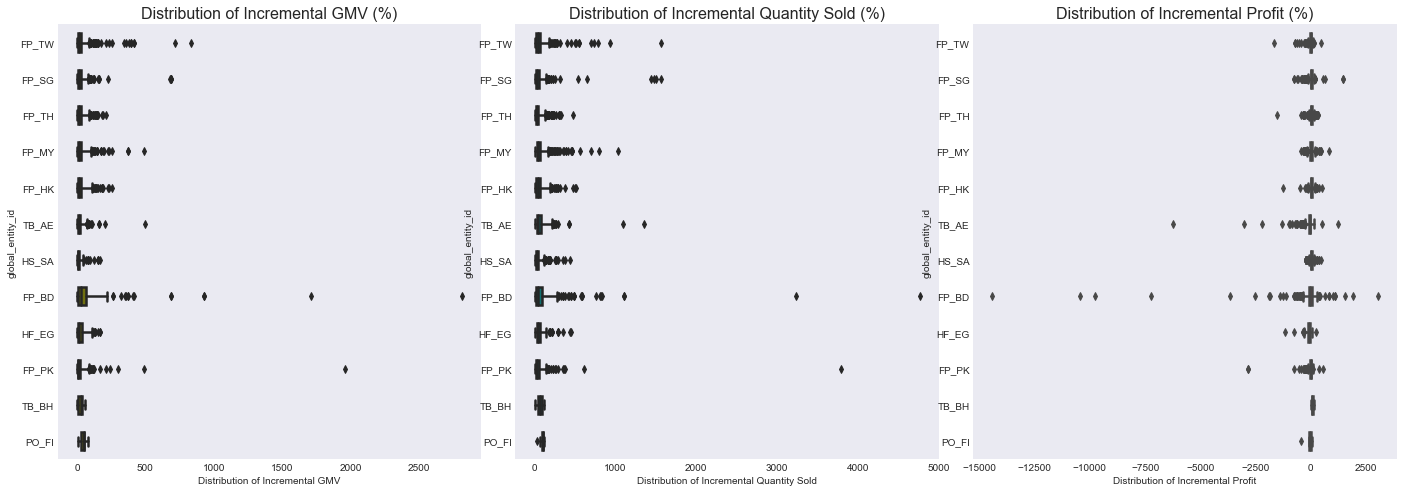

In [65]:
# Choose Columns
category_col = ['global_entity_id']
cols_of_interest = ['incremental_quantity_tab', 'incremental_gmv_tab','incremental_profit_ext_tab']
# Loop through Columns
for cols in cols_of_interest:
    display(df.groupby(category_col)[cols].describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).sort_values(by=['mean'], ascending = False).rename_axis(cols)\
                                                                                                                    .style.format({"count": "{0:.0f}", 
                                                                                                                          "mean": "{0:.2f}", 
                                                                                                                          "std": "{0:.2f}",
                                                                                                                          "min":"{0:.2f}",
                                                                                                                           "1%": "{0:.2f}",
                                                                                                                           "5%": "{0:.2f}",
                                                                                                                          "10%": "{0:.2f}",
                                                                                                                          "25%": "{0:.2f}",
                                                                                                                          "50%": "{0:.2f}",
                                                                                                                          "75%": "{0:.2f}",
                                                                                                                          "90%": "{0:.2f}",
                                                                                                                          "95%": "{0:.2f}",
                                                                                                                         "95%": "{0:.2f}",
                                                                                                                         "99%": "{0:.2f}",
                                                                                                                          "max": "{0:.2f}"})\
                                                                                                                       .background_gradient(cmap='BuPu'))

fig, ax = plt.subplots(1,3, figsize = (24,8), sharey=False)
plt.subplots_adjust(wspace = 0.08)

# GMV
sns.boxplot(x = 'incremental_gmv_tab', y= 'global_entity_id', data = df, ax = ax[0], color = 'olive', whis = 3, width = 0.5, linewidth = 2.5)
ax[0].set_title('Distribution of Incremental GMV (%)', fontsize = 16)
ax[0].set_xlabel('Distribution of Incremental GMV')

# Quantity Sold
sns.boxplot(x = 'incremental_quantity_tab', y= 'global_entity_id', data = df, ax = ax[1], color = 'teal', whis = 3, width = 0.5, linewidth = 2.5)
ax[1].set_title('Distribution of Incremental Quantity Sold (%)', fontsize = 16)
ax[1].set_xlabel('Distribution of Incremental Quantity Sold')

# Quantity Sold
sns.boxplot(x = 'incremental_profit_ext_tab',y= 'global_entity_id', data = df, ax = ax[2], color = 'crimson', whis = 3, width = 0.5, linewidth = 2.5)
ax[2].set_title('Distribution of Incremental Profit (%)', fontsize = 16)
ax[2].set_xlabel('Distribution of Incremental Profit')

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
discount,,,,,,,,,,,,,,
PO_FI,10,24.20,8.34,10.00,10.90,14.50,19.00,20.25,23.00,25.00,35.50,37.75,39.55,40.00
TB_AE,508,23.31,12.00,3.00,5.00,8.00,10.00,15.00,20.00,30.00,36.30,50.00,60.93,82.00
TB_BH,11,20.55,14.31,5.00,5.00,5.00,5.00,7.50,20.00,29.50,33.00,41.50,48.30,50.00
HS_SA,675,17.88,11.22,1.00,2.00,5.00,7.00,10.00,15.00,20.00,35.00,43.00,50.00,75.00
HF_EG,267,17.46,9.10,1.00,4.00,5.30,7.00,11.00,17.00,21.00,29.00,34.00,51.00,51.00
FP_MY,1399,16.89,8.72,1.00,5.00,5.00,9.00,10.00,15.00,22.00,25.00,30.00,50.00,58.00
FP_TW,1281,15.37,10.76,1.00,2.00,3.00,5.00,8.00,12.00,20.00,32.00,39.00,50.00,59.00
FP_HK,1458,14.64,9.22,1.00,3.00,4.00,5.00,9.00,12.00,18.00,28.00,33.00,47.43,76.00
FP_SG,2100,13.55,8.06,1.00,2.00,4.00,5.00,8.00,12.00,18.00,22.00,27.00,50.00,78.00


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
externally_funded_percentage,,,,,,,,,,,,,,
TB_BH,11,100.00,0.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
FP_TH,1167,89.14,27.14,0.00,0.00,0.00,79.60,97.00,100.00,100.00,100.00,100.00,100.00,100.00
HS_SA,675,77.90,39.01,0.00,0.00,0.00,0.00,50.00,100.00,100.00,100.00,100.00,100.00,100.00
FP_HK,1458,72.84,44.32,0.00,0.00,0.00,0.00,0.00,100.00,100.00,100.00,100.00,100.00,100.00
FP_SG,2100,62.34,41.30,0.00,0.00,0.00,0.00,4.00,80.00,100.00,100.00,100.00,100.00,100.00
FP_MY,1399,60.61,32.47,0.00,0.00,0.00,0.00,50.00,80.00,80.00,87.20,100.00,100.00,100.00
FP_BD,566,31.29,45.67,0.00,0.00,0.00,0.00,0.00,0.00,100.00,100.00,100.00,100.00,100.00
FP_PK,568,14.66,26.09,0.00,0.00,0.00,0.00,0.00,0.00,50.00,50.00,50.00,100.00,100.00
TB_AE,508,12.69,29.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,68.30,100.00,100.00,100.00


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
number_of_campaign_days,,,,,,,,,,,,,,
FP_TW,1281,525.18,3655.33,0.00,0.00,0.00,1.00,3.00,13.00,102.00,239.00,247.00,28821.00,28821.00
TB_AE,508,32.96,62.03,0.00,0.00,1.00,1.00,5.00,9.00,26.00,120.00,211.00,220.00,274.00
TB_BH,11,23.91,52.46,1.00,1.10,1.50,2.00,3.50,6.00,15.00,18.00,99.50,164.70,181.00
FP_BD,566,22.72,14.83,0.00,0.00,2.00,6.00,11.00,26.00,30.00,31.00,47.00,71.00,151.00
FP_SG,2100,16.31,15.87,0.00,1.00,3.00,5.00,7.00,7.00,28.00,31.00,35.05,90.00,123.00
FP_HK,1458,16.26,11.14,0.00,0.00,1.00,5.00,7.00,15.00,23.00,31.00,31.00,59.00,74.00
FP_PK,568,15.21,16.13,0.00,0.00,1.00,2.00,4.00,11.00,20.00,31.00,59.60,70.66,126.00
FP_TH,1167,13.44,11.58,0.00,1.00,2.00,4.00,7.00,9.00,16.00,29.40,31.00,75.38,80.00
HF_EG,267,12.17,5.33,0.00,0.00,0.00,5.00,10.00,13.00,15.00,21.00,21.00,21.00,21.00


Text(0.5, 0, 'Distribution of number of campaign days')

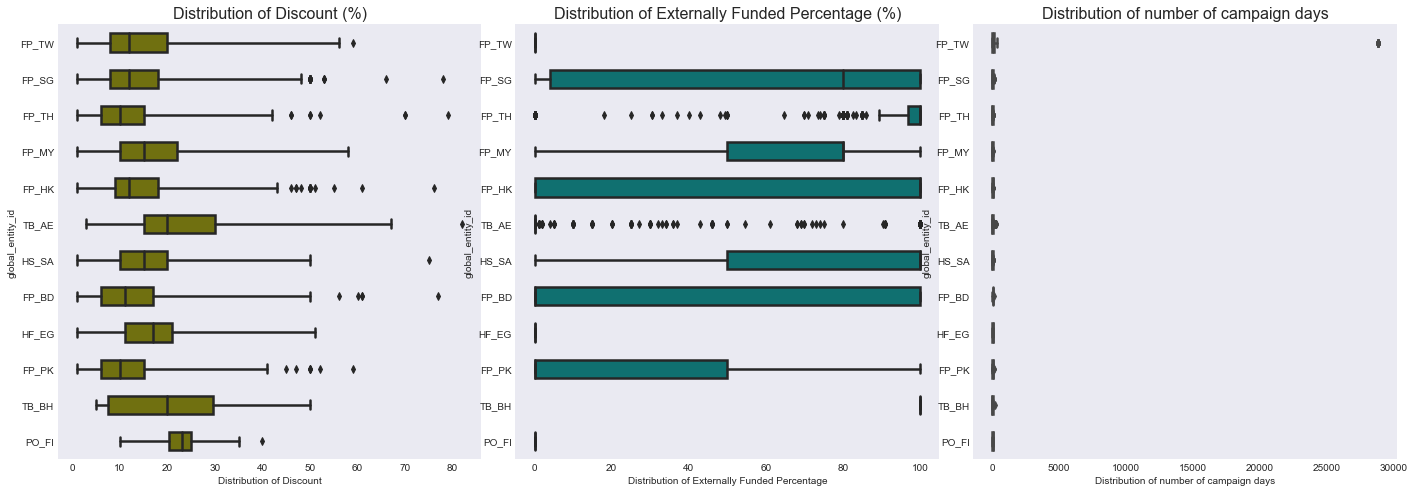

In [66]:
# Choose Columns

category_col = ['global_entity_id']
cols_of_interest = ['discount', 'externally_funded_percentage','number_of_campaign_days']
# Loop through Columns
for cols in cols_of_interest:
    display(df.groupby(category_col)[cols].describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).sort_values(by=['mean'], ascending = False).rename_axis(cols)\
                                                                                                                    .style.format({"count": "{0:.0f}", 
                                                                                                                          "mean": "{0:.2f}", 
                                                                                                                          "std": "{0:.2f}",
                                                                                                                          "min":"{0:.2f}",
                                                                                                                           "1%": "{0:.2f}",
                                                                                                                           "5%": "{0:.2f}",
                                                                                                                          "10%": "{0:.2f}",
                                                                                                                          "25%": "{0:.2f}",
                                                                                                                          "50%": "{0:.2f}",
                                                                                                                          "75%": "{0:.2f}",
                                                                                                                          "90%": "{0:.2f}",
                                                                                                                          "95%": "{0:.2f}",
                                                                                                                         "95%": "{0:.2f}",
                                                                                                                         "99%": "{0:.2f}",
                                                                                                                          "max": "{0:.2f}"})\
                                                                                                                       .background_gradient(cmap='Greens'))

fig, ax = plt.subplots(1,3, figsize = (24,8), sharey=False)
plt.subplots_adjust(wspace = 0.08)

# GMV
sns.boxplot(x = 'discount', y= 'global_entity_id', data = df, ax = ax[0], color = 'olive', whis = 3, width = 0.5, linewidth = 2.5)
ax[0].set_title('Distribution of Discount (%)', fontsize = 16)
ax[0].set_xlabel('Distribution of Discount')

# Quantity Sold
sns.boxplot(x = 'externally_funded_percentage', y= 'global_entity_id', data = df, ax = ax[1], color = 'teal', whis = 3, width = 0.5, linewidth = 2.5)
ax[1].set_title('Distribution of Externally Funded Percentage (%)', fontsize = 16)
ax[1].set_xlabel('Distribution of Externally Funded Percentage')

# Quantity Sold
sns.boxplot(x = 'number_of_campaign_days',y= 'global_entity_id', data = df, ax = ax[2], color = 'crimson', whis = 3, width = 0.5, linewidth = 2.5)
ax[2].set_title('Distribution of number of campaign days', fontsize = 16)
ax[2].set_xlabel('Distribution of number of campaign days')

#### Group Data by Country Level

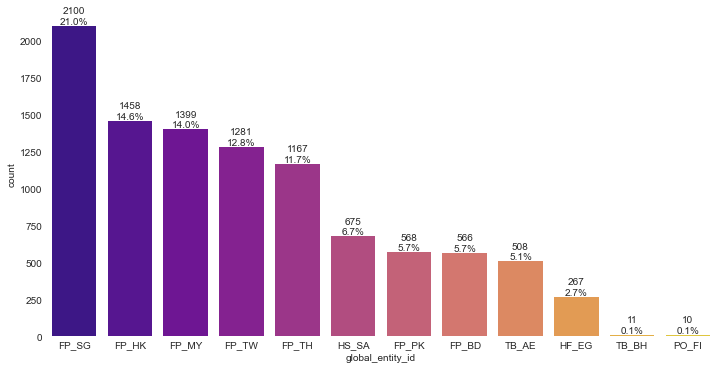

In [67]:
fig, ax = plt.subplots(figsize=(12, 6))
viz_utils.single_countplot(df, x='global_entity_id', ax=ax)
plt.show()

In [68]:
countries_agg = df.groupby(by='global_entity_id', as_index=False).agg({'incremental_gmv_tab': 'mean',
                                                                        'incremental_quantity_tab': 'mean',
                                                                        'incremental_profit_ext_tab': 'mean',
                                                                        'discount':'mean',
                                                                        'externally_funded_percentage': 'mean'})
countries_agg.columns = ['country', 'mean_incremental_gmv', 'mean_incremental_quantity', 'mean_incremental_profit_ext', 'mean_discount', 'mean_externally_funded_percentage']
countries_agg = countries_agg.sort_values(by='mean_incremental_profit_ext', ascending=False)
countries_agg = countries_agg.loc[:, ['country', 'mean_incremental_gmv', 'mean_incremental_quantity', 'mean_incremental_profit_ext', 'mean_discount', 'mean_externally_funded_percentage']]
countries_agg.sort_values(by='mean_incremental_profit_ext',ascending = False).reset_index(drop = True).style.set_properties(**{                                                  
                                    'color': 'white',                       
                                    'border-color': 'white'})\
                         .format({"BasePay": "${:20,.0f}", 
                          "mean_incremental_gmv": "{0:.2f}", 
                          "mean_incremental_quantity": "{0:.2f}",
                          "mean_incremental_profit_ext": "{0:.2f}",
                        "mean_discount": "{0:.2f}",                                                                                          
                          "mean_externally_funded_percentage":"{0:.2f}"})\
                 .hide_index()\
                .background_gradient(subset=['mean_incremental_gmv','mean_incremental_quantity','mean_incremental_profit_ext'], cmap='RdYlGn')\
                .background_gradient(subset=['mean_discount', 'mean_externally_funded_percentage'], cmap='Blues')

country,mean_incremental_gmv,mean_incremental_quantity,mean_incremental_profit_ext,mean_discount,mean_externally_funded_percentage
TB_BH,25.62,63.92,63.80,20.55,100.00
FP_TH,22.48,41.75,28.26,11.90,89.14
FP_HK,25.05,49.61,26.77,14.64,72.84
HS_SA,12.48,42.11,20.43,17.88,77.90
FP_SG,21.61,44.15,4.40,13.55,62.34
FP_MY,25.41,55.24,-4.78,16.89,60.61
FP_TW,25.65,52.73,-25.58,15.37,0.00
FP_PK,25.15,47.30,-33.67,11.95,14.66
PO_FI,45.10,92.42,-69.28,24.20,0.00
TB_AE,18.66,63.34,-91.95,23.31,12.69


<AxesSubplot:xlabel='mean_incremental_gmv', ylabel='country'>

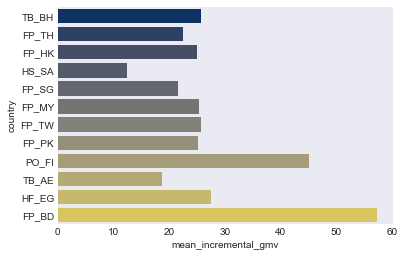

In [69]:
sns.barplot(y = 'country', x = 'mean_incremental_gmv', data = countries_agg, palette = 'cividis')

<AxesSubplot:xlabel='mean_incremental_profit_ext', ylabel='country'>

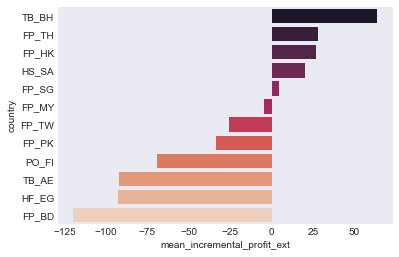

In [70]:
sns.barplot(y = 'country', x = 'mean_incremental_profit_ext', data = countries_agg, palette = 'rocket')

#### Simple Correlation Checks

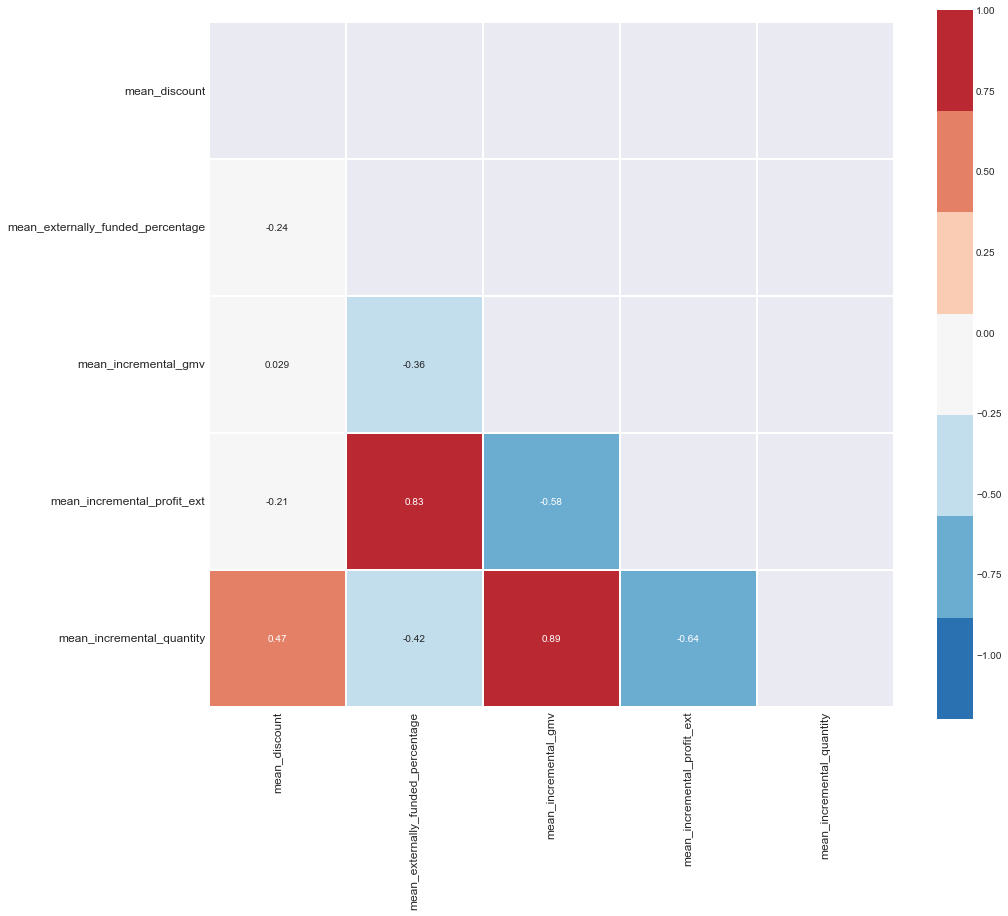

In [71]:
# order columns
rship = countries_agg[countries_agg.columns.sort_values()]

# plot heatmap
mask = np.zeros_like(rship.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(15, 20))
sns.heatmap(rship.corr(),
            mask = mask,
            square=True,
            vmin = -1.2,
            vmax = 1,
            linewidth=0.1,
            cbar_kws = {'shrink':0.5},
            cmap=sns.color_palette("RdBu_r", 7), annot=True)
ax.tick_params(labelsize=12)
plt.tight_layout()

#### What correlates most with profitability?

                                   mean_incremental_profit_ext
mean_incremental_profit_ext                           1.000000
mean_externally_funded_percentage                     0.826548
mean_incremental_quantity                             0.637013
mean_incremental_gmv                                  0.582752
mean_discount                                         0.205385


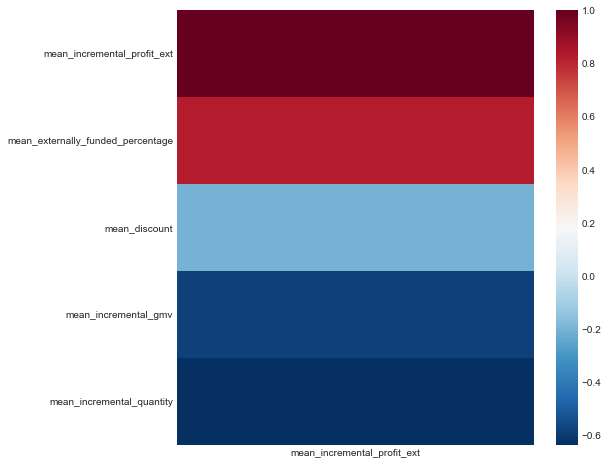

In [72]:
print(np.abs(countries_agg.corr())[['mean_incremental_profit_ext']].sort_values('mean_incremental_profit_ext', ascending=False).head(10))
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(countries_agg.corr()[['mean_incremental_profit_ext']].sort_values('mean_incremental_profit_ext'),
             cmap='RdBu_r', ax=ax);
ax.invert_yaxis()

In [73]:
# Create new columns
df['price_difference'] = df['price_base'] - df['price']
df['y_pred_uplift'] = df['y_pred'] - df['y_pred_base']
df['y_pred_uplift_perc'] = (df['y_pred'] - df['y_pred_base'])/df['y_pred_base'] * 100
df['qty_uplift'] = df['qty_sold'] - df['b_qty']
df['qty_uplift_perc'] = (df['qty_sold'] - df['b_qty'])/df['b_qty'] * 100
df['gmv_uplift'] =  df['gmv'] - df['b_gmv'] 
df['gmv_uplift_perc'] = ((df['gmv'] - df['b_gmv'])/df['b_gmv']) * 100
df['profit_ext_uplift'] = df['profit_ext'] - df['b_profit']
df['profit_ext_uplift_perc'] = ((df['profit_ext'] - df['b_profit'])/df['b_profit']) * 100

#### Rows where the predicted quantity sold baseline (without discount) is higher than what is predicted qty sold (after discount)

In [74]:
print(f'Percentage rows where y_pred_base > y_pred: {np.round(df.query("y_pred_base > y_pred").shape[0]/df.shape[0] * 100,2)}%')
df.query('y_pred_base > y_pred')[['order_date','global_entity_id','campaign_name','product','sku','y_pred_base','y_pred','y_pred_uplift','y_pred_uplift_perc']].sort_values(by=['y_pred_uplift_perc']).head()

Percentage rows where y_pred_base > y_pred: 0.0%


,order_date,global_entity_id,campaign_name,product,sku,y_pred_base,y_pred,y_pred_uplift,y_pred_uplift_perc


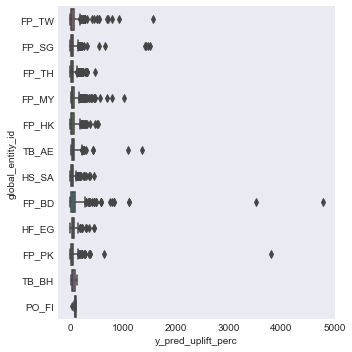

In [75]:
sns.catplot(x='y_pred_uplift_perc', 
            y = 'global_entity_id',
            data=df, 
            kind ='box',
            whis = 3)

In [76]:
df.query('y_pred_uplift_perc > 12000')[['order_date','global_entity_id','campaign_name','product','sku','y_pred_base','y_pred','y_pred_uplift','y_pred_uplift_perc']].sort_values(by=['y_pred_uplift_perc']).head()

,order_date,global_entity_id,campaign_name,product,sku,y_pred_base,y_pred,y_pred_uplift,y_pred_uplift_perc


#### Rows where Price after discount is higher than Price before discount

In [77]:
print(f'Percentage rows where Price > Price_Base: {np.round(df.query("price > price_base").shape[0]/df.shape[0] * 100,2)}%')
df.query("price > price_base")[['order_date','global_entity_id','campaign_name','product','sku','price','price_base','price_difference']].sort_values(by=['price_difference']).head()

Percentage rows where Price > Price_Base: 0.0%


,order_date,global_entity_id,campaign_name,product,sku,price,price_base,price_difference


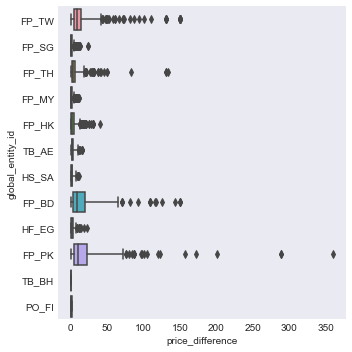

In [78]:
sns.catplot(x='price_difference', 
            y = 'global_entity_id',
            data=df, 
            kind ='box',
            whis = 3)

In [79]:
df.query("price_difference > 400")[['order_date','global_entity_id','campaign_name','product','sku','price','price_base','price_difference']].sort_values(by=['price_difference']).head()

,order_date,global_entity_id,campaign_name,product,sku,price,price_base,price_difference


#### Rows where Baseline Quantity > Quantity Sold

In [80]:
print(f'Percentage rows where Baseline Quantity > Quantity: {np.round(df.query("b_qty > qty_sold").shape[0]/df.shape[0] * 100,2)}%')
df.query("b_qty > qty_sold")[['order_date','global_entity_id','campaign_name','product','sku','qty_sold','b_qty','qty_uplift','qty_uplift_perc']].sort_values(by=['qty_uplift_perc']).head()

Percentage rows where Baseline Quantity > Quantity: 0.0%


,order_date,global_entity_id,campaign_name,product,sku,qty_sold,b_qty,qty_uplift,qty_uplift_perc


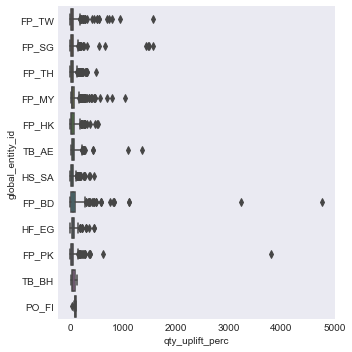

In [81]:
sns.catplot(x='qty_uplift_perc', 
            y = 'global_entity_id',
            data=df, 
            kind ='box',
            whis = 3)

In [82]:
df.query("qty_uplift_perc > 8000")[['order_date','global_entity_id','campaign_name','product','sku','qty_sold','b_qty','qty_uplift','qty_uplift_perc']].sort_values(by=['qty_uplift_perc'], ascending = False).head()

,order_date,global_entity_id,campaign_name,product,sku,qty_sold,b_qty,qty_uplift,qty_uplift_perc


#### Rows where Baseline GMV > GMV

In [83]:
print(f'Percentage rows where Baseline GMV > GMV: {np.round(df.query("b_gmv > gmv").shape[0]/df.shape[0] * 100,2)}%')
df.query("b_gmv > gmv")[['order_date','global_entity_id','campaign_name','product','sku','gmv','b_gmv','gmv_uplift','gmv_uplift_perc']].sort_values(by=['gmv_uplift_perc']).head()

Percentage rows where Baseline GMV > GMV: 0.0%


,order_date,global_entity_id,campaign_name,product,sku,gmv,b_gmv,gmv_uplift,gmv_uplift_perc


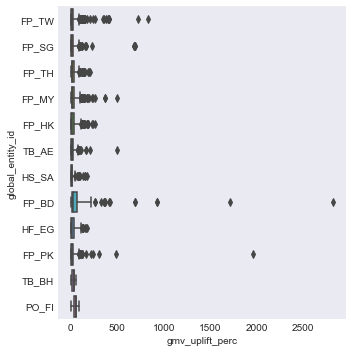

In [84]:
sns.catplot(x='gmv_uplift_perc', 
            y = 'global_entity_id',
            data=df, 
            kind ='box',
            whis = 3)

In [85]:
df.query('gmv_uplift_perc > 3000')[['global_entity_id','product','sku','campaign_name','b_gmv','gmv','gmv_uplift','gmv_uplift_perc']].sort_values(by=['gmv_uplift_perc'], ascending = False).head()

,global_entity_id,product,sku,campaign_name,b_gmv,gmv,gmv_uplift,gmv_uplift_perc


#### Rows where b_profit > profit_ext

In [86]:
print(f'Percentage rows where Baseline Profit > Profit External: {np.round(df.query("b_profit > profit_ext").shape[0]/df.shape[0] * 100,2)}%')
df.query("b_profit > profit_ext")[['order_date','global_entity_id','campaign_name','product','sku','profit','profit_ext','b_profit','profit_ext_uplift','profit_ext_uplift_perc','incremental_profit_ext_tab']].sort_values(by=['profit_ext_uplift_perc']).tail()

Percentage rows where Baseline Profit > Profit External: 42.69%


,order_date,global_entity_id,campaign_name,product,sku,profit,profit_ext,b_profit,profit_ext_uplift,profit_ext_uplift_perc,incremental_profit_ext_tab
2085,2021-04-05,FP_BD,Perishable_Fruits & Vegetable_all_flat_50P_All_WK1_Apr21_V1,Local Garlic (Roshun) 500 gm,J7J791,-258.21,-258.21,-23.86,-234.35,982.187762,982.187762
678,2020-12-12,TB_AE,UAE - additional flash sales[CLONE],Arwa Drinking Water 1.5 L,900876,-49.20,-49.20,-3.76,-45.44,1208.510638,1208.510638
6820,2021-09-26,FP_BD,own_funded_eggs_salt_20Sep_v1,Egg Broiler 12 Pcs (45 gm+ Per Pc),P421S6,-1728.00,-1728.00,-106.27,-1621.73,1526.046862,1526.046862
3696,2021-03-31,FP_BD,Perishable_Fruits & Vegetable_all_flat_50P_All_WK1_Apr21_V1,New Potato (Notun Aloo) 1 Kg,73QQ6B,-919.70,-919.70,-46.25,-873.45,1888.540541,1888.540541
3496,2021-04-20,FP_BD,Perishable_Hook_Potato_Apr21_v3,New Potato (Notun Aloo) 1 Kg,73QQ6B,-765.00,-765.00,-24.52,-740.48,3019.902121,3019.902121


#### Rows where Profit > Profit with External Funding

In [87]:
df['external_funding_calc_from_profit'] = df['profit_ext'] - df['profit']
print(f'Percentage rows where Profit > Profit with External Funding: {np.round(df.query("profit > profit_ext").shape[0]/df.shape[0] * 100,2)}%')
df.query("profit > profit_ext")[['order_date','global_entity_id','campaign_name','product','sku','profit','profit_ext','external_funding_calc_from_profit', 'externally_funded_percentage']].sort_values(by=['external_funding_calc_from_profit']).head()

Percentage rows where Profit > Profit with External Funding: 0.0%


,order_date,global_entity_id,campaign_name,product,sku,profit,profit_ext,external_funding_calc_from_profit,externally_funded_percentage


#### Rows where Discounts > 100

In [88]:
print(f'Percentage rows where Discount > 100: {np.round(df.query("discount > 100").shape[0]/df.shape[0] * 100,4)}%')
df.query("discount > 100")[['order_date','global_entity_id','campaign_name','product','sku','discount']].sort_values(by=['discount'],ascending = False).head()

Percentage rows where Discount > 100: 0.0%


,order_date,global_entity_id,campaign_name,product,sku,discount


#### Rows where Externally Funded Percentage > 100

In [89]:
print(f'Percentage rows where Externally Funded Percentage > 100: {np.round(df.query("externally_funded_percentage > 100").shape[0]/df.shape[0] * 100,2)}%')
df.query("externally_funded_percentage > 100")[['order_date','global_entity_id','campaign_name','product','sku','externally_funded_percentage']].sort_values(by=['externally_funded_percentage'],ascending = False).head()

Percentage rows where Externally Funded Percentage > 100: 0.0%


,order_date,global_entity_id,campaign_name,product,sku,externally_funded_percentage


#### Rows where Creation of campaign is after is start date

In [90]:
df['no_of_days_created_after_start'] = (df['campaign_created_time_utc'] - df['campaign_start_time_utc']).dt.days

In [91]:
df.query("no_of_days_created_after_start > 3")[['order_date','global_entity_id','campaign_name','product','sku','campaign_created_time_utc','campaign_start_time_utc','no_of_days_created_after_start']].sort_values(by=['campaign_created_time_utc'], 
ascending = False).head()

,order_date,global_entity_id,campaign_name,product,sku,campaign_created_time_utc,campaign_start_time_utc,no_of_days_created_after_start


#### Great Expectations

In [92]:
import great_expectations as ge

ModuleNotFoundError: No module named 'great_expectations'

In [ ]:
my_df = ge.from_pandas(df)

In [ ]:
my_df.expect_column_values_to_be_between(['discount'],0,100)

{
  "meta": {},
  "success": true,
  "result": {
    "element_count": 10167,
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_count": 1,
    "unexpected_percent": 0.009835743090390479,
    "unexpected_percent_total": 0.009835743090390479,
    "unexpected_percent_nonmissing": 0.009835743090390479,
    "partial_unexpected_list": [
      "discount"
    ]
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  }
}

In [ ]:
df.query("discount > 100")[['order_date','global_entity_id','campaign_name','product','sku','discount']].sort_values(by=['discount'],ascending = False).head()

,order_date,global_entity_id,campaign_name,product,sku,discount


In [ ]:
# Qty_sold should be greater than Baseline Quantity
my_df.expect_column_pair_values_A_to_be_greater_than_B("qty_sold", "b_qty",or_equal = True)

{
  "meta": {},
  "success": true,
  "result": {
    "element_count": 10167,
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_count": 0,
    "unexpected_percent": 0.0,
    "unexpected_percent_total": 0.0,
    "unexpected_percent_nonmissing": 0.0,
    "partial_unexpected_list": []
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  }
}

In [ ]:
my_df.get_expectation_suite(discard_failed_expectations=False)

{
  "meta": {
    "great_expectations_version": "0.13.41"
  },
  "data_asset_type": "Dataset",
  "expectations": [
    {
      "expectation_type": "expect_column_values_to_be_between",
      "meta": {},
      "kwargs": {
        "column": [
          "discount"
        ],
        "min_value": 0,
        "max_value": 100
      },
      "ge_cloud_id": null
    },
    {
      "expectation_type": "expect_column_pair_values_A_to_be_greater_than_B",
      "meta": {},
      "kwargs": {
        "column_A": "qty_sold",
        "column_B": "b_qty",
        "or_equal": true
      },
      "ge_cloud_id": null
    }
  ],
  "ge_cloud_id": null,
  "expectation_suite_name": "default"
}